First try reconstructing these spectra with an autoencoder.  Just because I already have code in hand for that.

In [1]:
def isNaN(string):
    return string != string

In [3]:
from tensorflow import keras
#import keras

from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import richardsplot
import os

In [4]:
import tensorflow as tf
tf.__version__, keras.__version__

('1.12.0', '2.1.6-tf')

In [5]:
dat = pd.read_csv("../data/ParentSample_DR7props.csv")
dat.head()

A_morph           SDSS_NAME          RA        DEC  REDSHIFT  PLATE  FIBER  \
0       D  093509.48+481910.2  143.789520  48.319504    0.2238    834    361   
1       E  152925.98+021646.6  232.358261   2.279618    0.2634   2954    379   
2       E  144414.66+063306.7  221.061111   6.551877    0.2080   1829    464   
3       E  140808.19+430316.5  212.034164  43.054600    0.2581   1467     48   
4       E  172711.80+632242.1  261.799194  63.378372    0.2174    352    639   

     MJD  TARGET_FLAG_TARGET  NSPECOBS  ...    f_c   logL     i_2   I_2a  \
0  52316                7691         1  ...  1.000  22.92  17.026 -22.73   
1  54561                   3         1  ...  1.000  22.47  17.490 -22.61   
2  53494           135273475         1  ...  1.000  22.47  16.552 -23.04   
3  53115                7171         1  ...  1.000  22.99  16.922 -23.14   
4  51789                7168         2  ...  1.000  22.97  16.730 -22.95   

      R         LD_cm       Lobs   L_1.4GHz  SFR (Msun/yr)  Separation  
0  1.07  3.434469e+27  22.949804  23.453667     167.694491         0.0  
1  0.41  4.120027e+27  22.510854  23.024252      62.388456         0.0  
2  0.29  3.160119e+27  22.505157  23.005020      59.685944         0.0  
3  0.85  4.030828e+27  23.028500  23.540693     204.901363         0.0  
4  0.99  3.313937e+27  23.002030  23.504149     188.365559         0.0  

[5 rows x 163 columns]

In [6]:
train = pd.read_csv("../data/trainsample_dr7_zlt0.358.csv")
train.head()

Unnamed: 0              SDSS_NAME        RA        DEC  REDSHIFT  PLATE  \
0          48  b'000102.18-102326.9'  0.259118 -10.390822    0.2943    650   
1          81  b'000149.52-100251.8'  0.456358 -10.047724    0.3578    650   
2         157  b'000410.80-104527.1'  1.045027 -10.757537    0.2397    650   
3         233  b'000557.23+002837.7'  1.488499   0.477143    0.2596    388   
4         235  b'000601.82-052845.0'  1.507606  -5.479184    0.3295   2630   

   FIBER    MJD  
0    166  52143  
1    152  52143  
2     18  52143  
3    385  51793  
4    149  54327

In [9]:
sdss_name_full = train["SDSS_NAME"].values
z_full         = train["REDSHIFT"].values
plate_full     = train["PLATE"].values
mjd_full       = train["MJD"].values
fiber_full     = train["FIBER"].values

In [14]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
names   = []
spectra = []
wave    = []
ivar    = []
found   = [] #save dataframe indices which have spectra
N = 0

for sdss_name, red, pl, mj, fib in zip(sdss_name_full, z_full, plate_full, mjd_full, fiber_full):
    try:
        hdul_spec = fits.open("../data/spectra/train/zlt0p6_dr7/lite/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        #print("../data/spectra/train/zlt0p6_dr7/lite/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>=4000) & (sdss_wave<=6750)) #include Halpha
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(sdss_flux) >= 2272:
        names.append(sdss_name[:2272])
        spectra.append(sdss_flux[:2272])
        wave.append(sdss_wave[:2272])
        ivar.append(sdss_ivar[:2272])
        found.append(N)

    N+=1
    if N%1000==0: print(N)  
    
spectra = np.array(spectra)
wave    = np.array(wave)
ivar    = np.array(ivar)
found   = np.array(found)

1000
2000
3000


In [16]:
spectra

array([[14.453294 , 15.508008 , 14.963545 , ...,  9.951537 , 10.234952 ,
         8.803699 ],
       [ 7.602832 ,  8.600404 ,  7.465859 , ...,  4.872083 ,  6.242282 ,
         3.2730827],
       [28.543781 , 28.995981 , 30.414198 , ..., 15.39337  , 15.594685 ,
        15.456948 ],
       ...,
       [12.116452 , 12.15206  , 10.742563 , ...,  6.3495073,  6.5535727,
         7.485681 ],
       [13.731469 , 13.248561 , 12.606498 , ..., 12.045297 ,  8.145015 ,
         9.557875 ],
       [13.475461 , 14.51741  , 15.833292 , ...,  8.811812 ,  8.623327 ,
         8.206344 ]], dtype=float32)

---

Now build the autoencoder.  See for example Chapter 17 of Geron, Hands-on Machine Learning w/ Sci-kit Learn and Keras

In [19]:
spectra.shape

(3806, 2272)

In [20]:
norm_coeffs = np.median(spectra, axis=1)[:, np.newaxis]
spectra_norm = spectra / norm_coeffs
wave_norm = wave.copy()

In [21]:
import tensorflow.keras.backend as K

In [22]:
#Mask CIV absorption
n_latent = 3
#MASKK= (~((wave[0]>1490)&(wave[0]<1546))).astype(int) #Mask CIV absorption
#MASK = K.variable(MASKK)

In [23]:
#Build the encoder - the dimension of the final layer is the dimension of the latent space
stacked_encoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=spectra_norm[0].shape),
    #keras.layers.Lambda(lambda x: x*MASK, input_shape=spectra_norm[0].shape), #this layer is the mask - turn off corresponding neurons
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(30, kernel_initializer="he_normal"),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(n_latent, kernel_initializer="he_normal")
])

#Build the decoder - given values in latent space, it will reconstruct the original spectrum
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(30, kernel_initializer="he_normal", input_shape=[n_latent]),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(spectra_norm[0].shape[0]) #no activation function since we want actual pixel values
])

#Now put them together
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

Now need to compile our model. The two main ingredients will be the loss function we choose, and the optimizer. Keep it simple for now, and just see what happens with mean square error and stochastic gradient descent.

In [29]:
stacked_ae.compile(loss="logcosh", optimizer=keras.optimizers.Nadam(lr=1e-5, beta_1=0.9, beta_2=0.999))

In [30]:
X_train = spectra_norm[:2000]
X_valid = spectra_norm[2000:3000]
X_test  = spectra_norm[3000:]

#X_train will be both the "input" (to the encoder) and the "target" (of the decoder) for the autoencoder
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 2s 804us/step - loss: 0.0124 - val_loss: 0.0134
Epoch 2/10
2000/2000 [==============================] - 1s 411us/step - loss: 0.0123 - val_loss: 0.0134
Epoch 3/10
2000/2000 [==============================] - 1s 438us/step - loss: 0.0123 - val_loss: 0.0134
Epoch 4/10
2000/2000 [==============================] - 1s 416us/step - loss: 0.0123 - val_loss: 0.0134
Epoch 5/10
2000/2000 [==============================] - 1s 418us/step - loss: 0.0123 - val_loss: 0.0133
Epoch 6/10
2000/2000 [==============================] - 1s 426us/step - loss: 0.0123 - val_loss: 0.0133
Epoch 7/10
2000/2000 [==============================] - 1s 455us/step - loss: 0.0123 - val_loss: 0.0133
Epoch 8/10
2000/2000 [==============================] - 1s 466us/step - loss: 0.0122 - val_loss: 0.0133
Epoch 9/10
2000/2000 [==============================] - 1s 450us/step - loss: 0.0122 - val_loss: 0.0133
Epoch 10/10
2000

In [128]:
X_train.shape

(6000, 1224)

In [31]:
reconst = stacked_ae.predict(np.array([X_valid[0]]))

In [32]:
fig = plt.figure(figsize=(8,5))

#plt.plot(wave[800], spectra[800])
plt.plot(wave_norm[2000], X_valid[0])
plt.plot(wave_norm[2000], reconst[0])
plt.show()

In [33]:
n_spectra = 25
reconst = stacked_ae.predict(np.array(X_test[:n_spectra]))

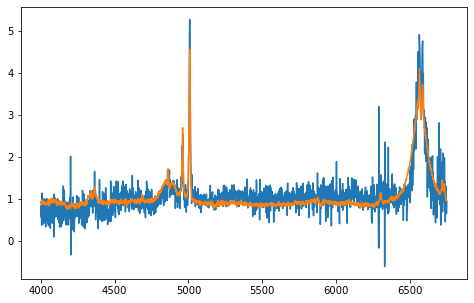

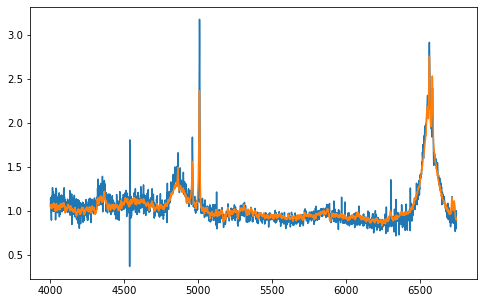

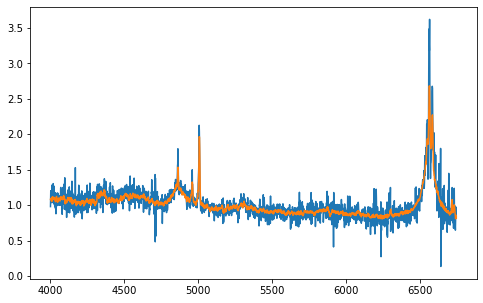

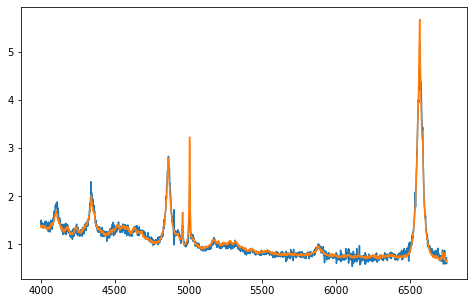

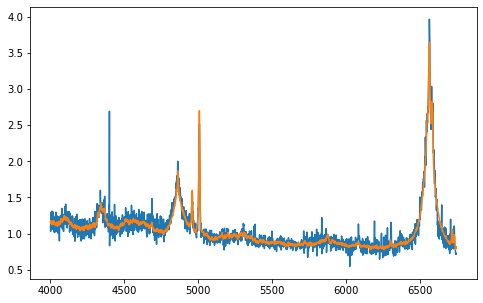

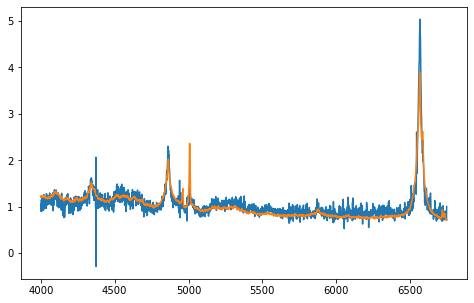

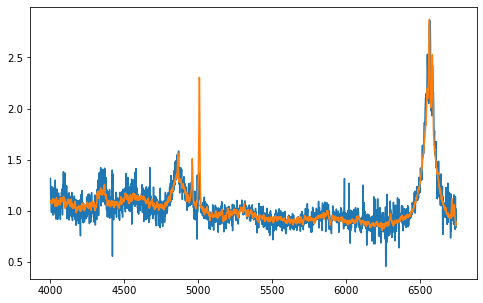

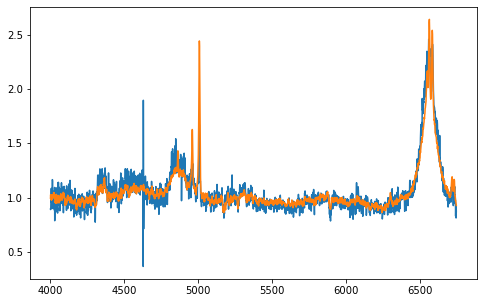

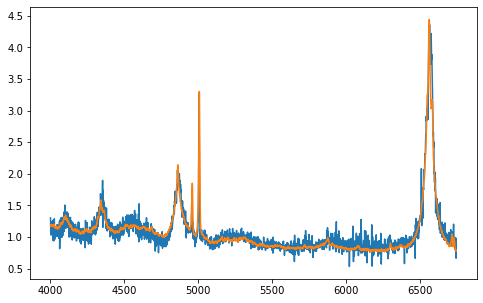

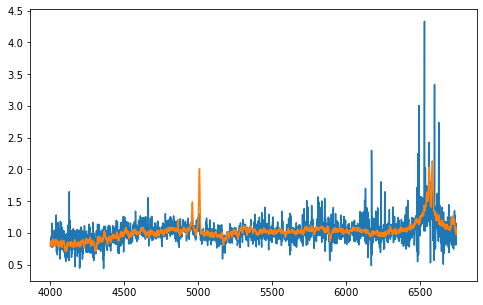

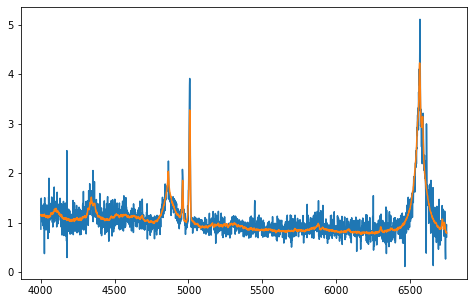

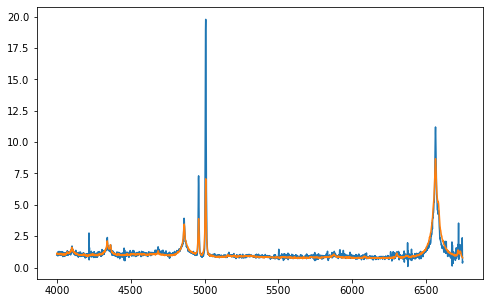

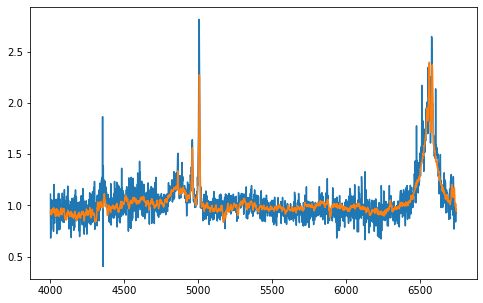

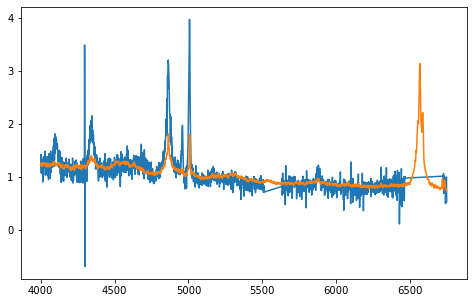

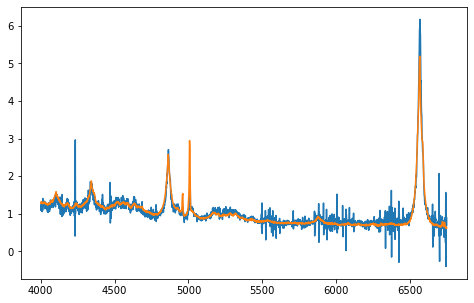

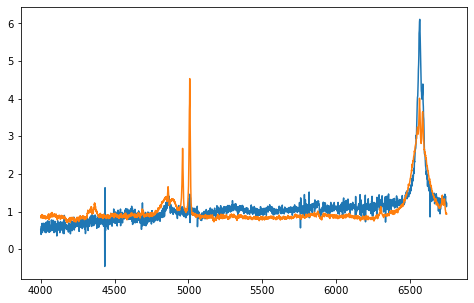

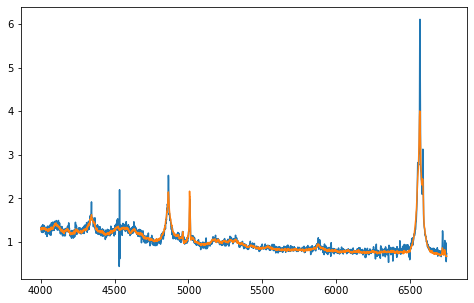

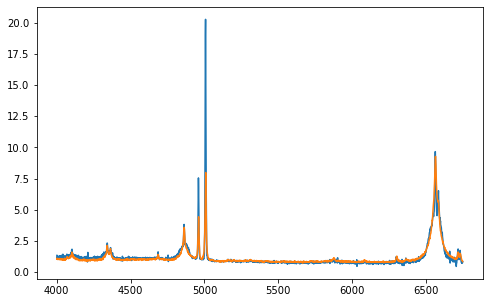

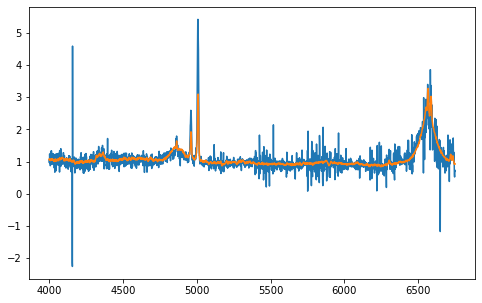

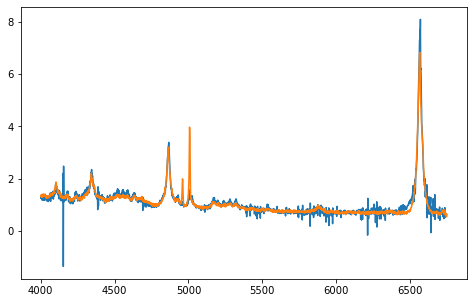

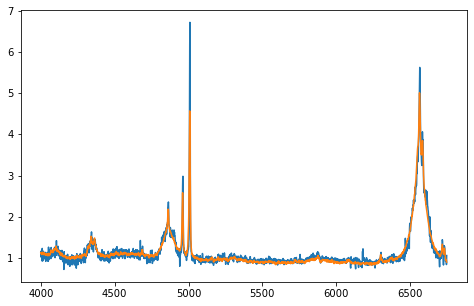

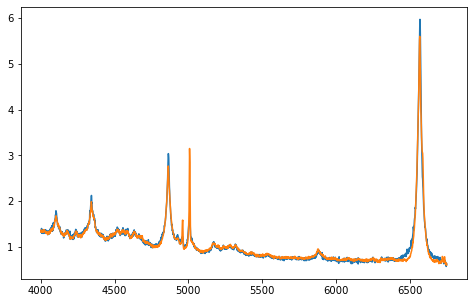

In [34]:
for i in range(n_spectra):
    #reconst = stacked_ae.predict(np.array([X_valid[i]]))
    fig = plt.figure(figsize=(8,5))
    plt.plot(wave_norm[3000+i], X_test[i])
    plt.plot(wave_norm[3000+i], reconst[i])
    plt.show()

---

Now see what each latent parameter "does".

In [35]:
def get_latent(X_comp, n, n_versions):
    #remove comments to plot - but this causes problems since noisy spectra are at extrema,
    #so just return spectra and choose which to plot
    
    #fig = plt.figure(figsize=(12,10))
    
    predictions = np.array([])
    
    #Set bounds to traverse when plotting differences
    low, high = np.min(X_comp[:,n]), np.max(X_comp[:,n])
    
    #get the median for all other values
    median = np.median(X_comp, axis=0)
    #median_other = np.delete(X_comp, n)
    
    #loop through min-->max and get corresponding spectra
    for i in np.linspace(low, high, n_versions): #maybe sample from logspace here instead?
        latent_params = median.copy()
        latent_params[n] = i
        predict = stacked_decoder.predict(np.array([latent_params]))
        
        if len(predictions) > 0:
            predictions = np.vstack([predictions, predict])
        else:
            predictions = np.append(predictions, predict)
        
        #plt.plot(wave[0], predict[0], alpha=0.6)
        
        
    #plt.show()
    
    return predictions

In [36]:
#Compress the spectra down to Nlatent dimensions
X = np.vstack([X_train, X_valid, X_test])
X_compressed = stacked_encoder.predict(X)

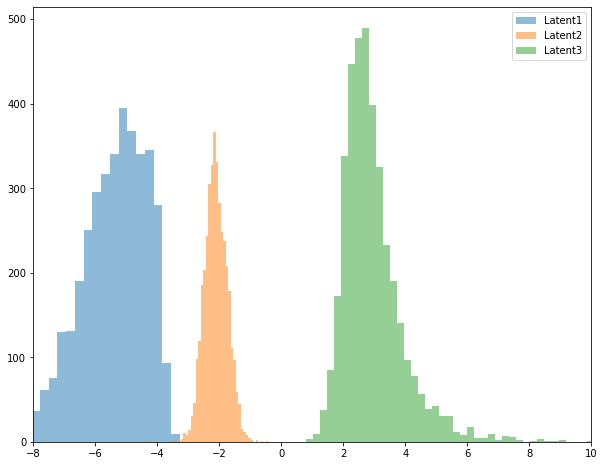

In [37]:
fig = plt.figure(figsize=(10,8))
for i in range(X_compressed.shape[1]):
    _ = plt.hist(X_compressed[:,i],bins='scott', alpha=0.5, label="Latent{}".format(i+1))
plt.xlim(-8,10)
plt.legend(loc="best")
plt.show()

In [100]:
# t-SNE
from sklearn.manifold import TSNE
#Not sure what learning_rate does
#tsne2 = TSNE(n_components = 2, learning_rate=100)
tsne2 = TSNE(n_components = 2)
TSNE2 = tsne2.fit(X_compressed)
projTSNE2 = TSNE2.transform(X_compressed)
#np.save("tSNE2_Hewett2017.npy", projTSNE2)

AttributeError: 'TSNE' object has no attribute 'transform'

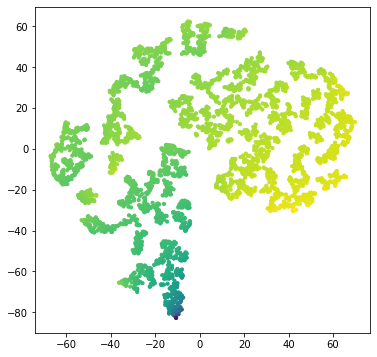

In [95]:
fig = plt.figure(figsize=(6,6))
plt.scatter(projTSNE2[:,0], projTSNE2[:,1], s=10, c=X_compressed[:,0])
plt.show()

In [38]:
n_diff = 4
prediction = np.array([[]])

predict1 = get_latent(X_compressed, 0, n_diff)
predict2 = get_latent(X_compressed, 1, n_diff)
predict3 = get_latent(X_compressed, 2, n_diff)
#predict4 = get_latent(X_compressed, 3, n_diff)
#predict5 = get_latent(X_compressed, 4, n_diff)
#predict6 = get_latent(X_compressed, 5, n_diff)

In [39]:
def plot_latent(prediction, omit=0, reverse=True):
    fig = plt.figure(figsize=(12,10))
    if reverse:
        for i in range(prediction.shape[0]-1-omit, -1, -1):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    else:
        for i in range(prediction.shape[0]-omit):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    plt.legend(loc="best")
    plt.show()

Param 1

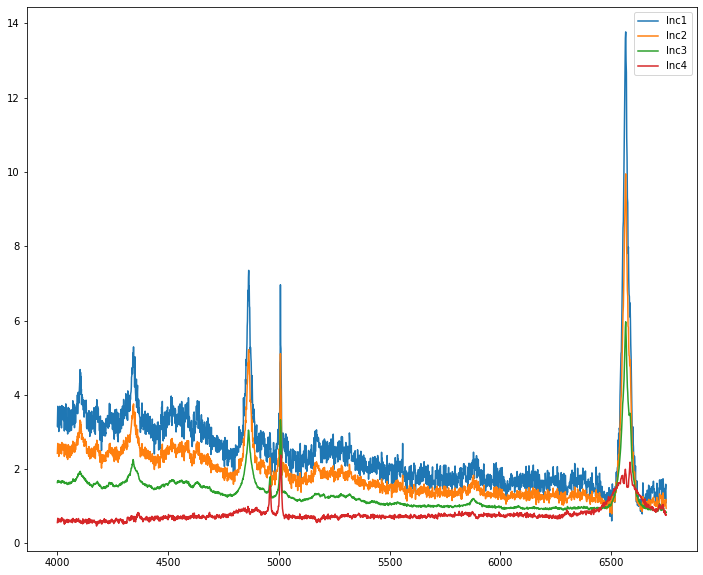

In [41]:
plot_latent(predict1, reverse=False)
#plot_latent(predict1, omit=1,  reverse=True)

---
Param 2

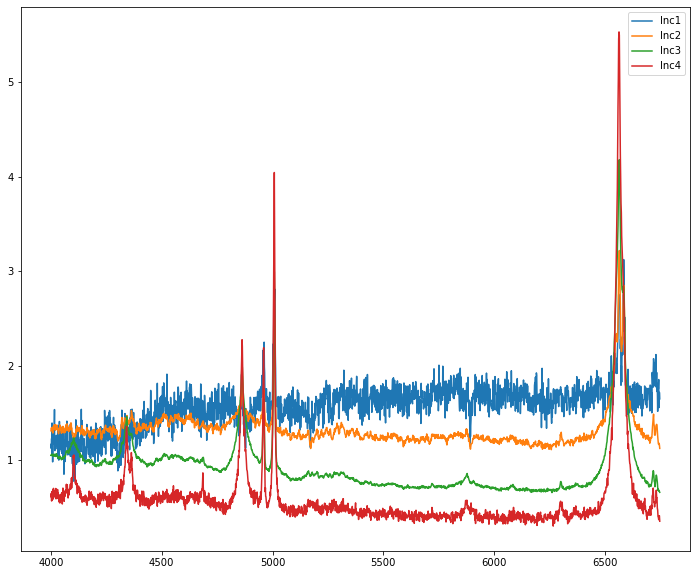

In [42]:
plot_latent(predict2, reverse=False)
#plot_latent(predict2, omit=3, reverse=True)

___
Param 3

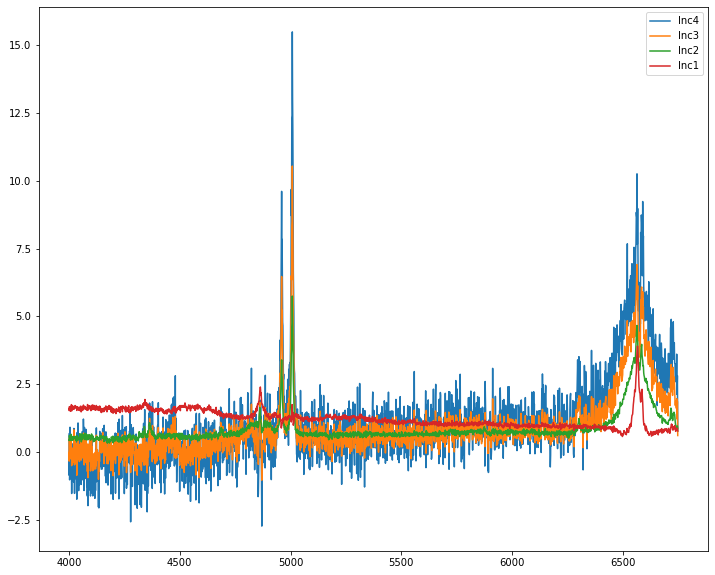

In [44]:
plot_latent(predict3, reverse=True)
#plot_latent(predict3, omit=5, reverse=False)

---
Param 4

---

Now reconstruct *our spectra* based on this model.

In [77]:
dat.sort_values("A_morph")

A_morph           SDSS_NAME          RA        DEC  REDSHIFT  PLATE  \
0         D  093509.48+481910.2  143.789520  48.319504    0.2238    834   
1         E  152925.98+021646.6  232.358261   2.279618    0.2634   2954   
2         E  144414.66+063306.7  221.061111   6.551877    0.2080   1829   
3         E  140808.19+430316.5  212.034164  43.054600    0.2581   1467   
4         E  172711.80+632242.1  261.799194  63.378372    0.2174    352   
..      ...                 ...         ...        ...       ...    ...   
173     NaN  092837.98+602521.0  142.158264  60.422504    0.2954    485   
174     NaN  093200.07+553347.4  143.000336  55.563171    0.2656    556   
175     NaN  093653.84+533126.8  144.224350  53.524124    0.2281    768   
176     NaN  094215.12+090015.8  145.563034   9.004406    0.2127   1305   
177     NaN  094603.94+013923.6  146.516434   1.656574    0.2203    480   

     FIBER    MJD  TARGET_FLAG_TARGET  NSPECOBS  ...    f_c   logL     i_2  \
0      361  52316                7691         1  ...  1.000  22.92  17.026   
1      379  54561                   3         1  ...  1.000  22.47  17.490   
2      464  53494           135273475         1  ...  1.000  22.47  16.552   
3       48  53115                7171         1  ...  1.000  22.99  16.922   
4      639  51789                7168         2  ...  1.000  22.97  16.730   
..     ...    ...                 ...       ...  ...    ...    ...     ...   
173    506  51909                7173         1  ...  0.104  25.34  17.000   
174    295  51991             2104853         1  ...  1.000  24.01  17.312   
175    473  52281             1048579         1  ...  1.000  22.13  16.465   
176    281  52757                   2         1  ...  1.000  23.15  16.788   
177    480  51989             2097173         1  ...  1.000  23.51  16.373   

      I_2a       R         LD_cm       Lobs   L_1.4GHz  SFR (Msun/yr)  \
0   -22.73    1.07  3.434469e+27  22.949804  23.453667     167.694491   
1   -22.61    0.41  4.120027e+27  22.510854  23.024252      62.388456   
2   -23.04    0.29  3.160119e+27  22.505157  23.005020      59.685944   
3   -23.14    0.85  4.030828e+27  23.028500  23.540693     204.901363   
4   -22.95    0.99  3.313937e+27  23.002030  23.504149     188.365559   
..     ...     ...           ...        ...        ...            ...   
173 -23.35  148.84  4.699743e+27  25.376085  25.897091   46552.449334   
174 -22.81   11.94  4.173728e+27  24.052318  24.566438    2174.153289   
175 -23.32    0.10  3.503693e+27  22.165986  22.670841      27.649846   
176 -22.85    1.66  3.245413e+27  23.186956  23.688075     287.691340   
177 -23.34    2.41  3.365498e+27  23.546181  24.049049     660.543632   

     Separation  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
..          ...  
173         NaN  
174         NaN  
175         NaN  
176         NaN  
177         NaN  

[178 rows x 163 columns]

In [78]:
dat.head()

A_morph           SDSS_NAME          RA        DEC  REDSHIFT  PLATE  FIBER  \
0       D  093509.48+481910.2  143.789520  48.319504    0.2238    834    361   
1       E  152925.98+021646.6  232.358261   2.279618    0.2634   2954    379   
2       E  144414.66+063306.7  221.061111   6.551877    0.2080   1829    464   
3       E  140808.19+430316.5  212.034164  43.054600    0.2581   1467     48   
4       E  172711.80+632242.1  261.799194  63.378372    0.2174    352    639   

     MJD  TARGET_FLAG_TARGET  NSPECOBS  ...    f_c   logL     i_2   I_2a  \
0  52316                7691         1  ...  1.000  22.92  17.026 -22.73   
1  54561                   3         1  ...  1.000  22.47  17.490 -22.61   
2  53494           135273475         1  ...  1.000  22.47  16.552 -23.04   
3  53115                7171         1  ...  1.000  22.99  16.922 -23.14   
4  51789                7168         2  ...  1.000  22.97  16.730 -22.95   

      R         LD_cm       Lobs   L_1.4GHz  SFR (Msun/yr)  Separation  
0  1.07  3.434469e+27  22.949804  23.453667     167.694491         0.0  
1  0.41  4.120027e+27  22.510854  23.024252      62.388456         0.0  
2  0.29  3.160119e+27  22.505157  23.005020      59.685944         0.0  
3  0.85  4.030828e+27  23.028500  23.540693     204.901363         0.0  
4  0.99  3.313937e+27  23.002030  23.504149     188.365559         0.0  

[5 rows x 163 columns]

In [79]:
sdss_name = dat["SDSS_NAME"].values
z         = dat["REDSHIFT"].values
plate     = dat["PLATE"].values
mjd       = dat["MJD"].values
fiber     = dat["FIBER"].values
A_morph = {
    "RL": isNaN(dat["A_morph"].values),
    "U": dat["A_morph"].values=="U",
    "D": dat["A_morph"].values=="D",
    "E": dat["A_morph"].values=="E",
    "M": dat["A_morph"].values=="M",
    "SR":dat["A_morph"].values=="SR",
    "ND":dat["A_morph"].values=="ND"
}

In [80]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
names   = []
spectra = []
wave    = []
ivar    = []
found   = [] #save dataframe indices which have spectra
N = 0

for sdss_name, red, pl, mj, fib in zip(sdss_name, z, plate, mjd, fiber):
    try:
        hdul_spec = fits.open("../data/spectra/kimballsample_full/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        print("../data/spectra/kimballsample_full/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>=4000) & (sdss_wave<=6750)) #Halpha wavelength range
    sdss_flux  = sdss_flux[wavemask]
    sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()

    if len(sdss_flux) >= 2272:
        names.append(sdss_name[:2272])
        spectra.append(sdss_flux[:2272])
        wave.append(sdss_wave[:2272])
        ivar.append(sdss_ivar[:2272])
        found.append(N)

    N+=1
    if N%1000==0: print(N)  
    
spectra = np.array(spectra)
wave    = np.array(wave)
ivar    = np.array(ivar)
found   = np.array(found)

In [81]:
spectra

array([[1.185528  , 1.1498858 , 1.1889162 , ..., 0.82231885, 0.8092116 ,
        0.7636687 ],
       [1.288299  , 1.3302782 , 1.3361462 , ..., 0.73795664, 0.73829615,
        0.729713  ],
       [1.310153  , 1.2782674 , 1.3562003 , ..., 0.7288241 , 0.7631892 ,
        0.7579614 ],
       ...,
       [1.2862287 , 1.2767252 , 1.2493023 , ..., 0.88017184, 0.7861134 ,
        0.77732486],
       [1.176908  , 1.1592349 , 1.0999246 , ..., 0.95313424, 0.9512434 ,
        0.94892603],
       [1.2163985 , 1.1926433 , 1.0693551 , ..., 0.87525135, 0.8512023 ,
        0.9141965 ]], dtype=float32)

In [82]:
spectra.shape

(178, 2272)

In [83]:
rqqs_compressed = stacked_encoder.predict(spectra)

In [84]:
rqqs_compressed

array([[ -8.378821  ,  -2.19102   ,   6.112128  ],
       [ -6.006679  ,  -1.9048744 ,   2.7754183 ],
       [ -7.5081296 ,  -1.9100364 ,   4.421514  ],
       [ -5.5607095 ,  -1.754548  ,   2.2388864 ],
       [ -4.339372  ,  -2.1600878 ,   1.8838183 ],
       [ -5.0670114 ,  -1.6032826 ,   1.4247266 ],
       [ -7.8119516 ,  -2.211495  ,   5.310244  ],
       [ -5.762275  ,  -1.9437251 ,   2.8667603 ],
       [ -8.660268  ,  -1.4943613 ,   4.686689  ],
       [ -4.2726865 ,  -2.010842  ,   1.6268936 ],
       [ -6.42398   ,  -1.3413297 ,   2.1432319 ],
       [ -6.6040277 ,  -1.9499122 ,   3.167154  ],
       [ -5.6451387 ,  -1.6459732 ,   2.143432  ],
       [ -6.202875  ,  -2.4208577 ,   4.090455  ],
       [ -5.1733785 ,  -1.8762143 ,   2.180908  ],
       [ -4.965452  ,  -1.7641535 ,   1.7563723 ],
       [ -4.4582357 ,  -2.1833544 ,   2.1113183 ],
       [ -6.5156984 ,  -1.6531426 ,   2.3584673 ],
       [ -8.401649  ,  -1.3579875 ,   3.872691  ],
       [ -6.6484785 ,  -2.08577

In [85]:
def plot_params(param1, param2):
    fig = plt.figure(figsize=(7,7))
    plt.scatter(rqqs_compressed[A_morph["U"],param1-1], rqqs_compressed[A_morph["U"],param2-1], label="U")
    plt.scatter(rqqs_compressed[A_morph["ND"],param1-1], rqqs_compressed[A_morph["ND"],param2-1], label="ND")
    #plt.scatter(rqqs_compressed[A_morph["SR"],param1-1], rqqs_compressed[A_morph["SR"],param2-1], label="SR")
    plt.scatter(rqqs_compressed[A_morph["D"],param1-1], rqqs_compressed[A_morph["D"],param2-1], label="D")
    plt.scatter(rqqs_compressed[A_morph["E"],param1-1], rqqs_compressed[A_morph["E"],param2-1], label="E")
    plt.scatter(rqqs_compressed[A_morph["M"],param1-1], rqqs_compressed[A_morph["M"],param2-1], label="M")
    plt.scatter(rqqs_compressed[A_morph["RL"],param1-1], rqqs_compressed[A_morph["RL"],param2-1], color="pink", label="RL")
    plt.xlabel("Latent Param %d"%param1)
    plt.ylabel("Latent Param %d"%param2)
    plt.legend(loc="best")
    plt.show()

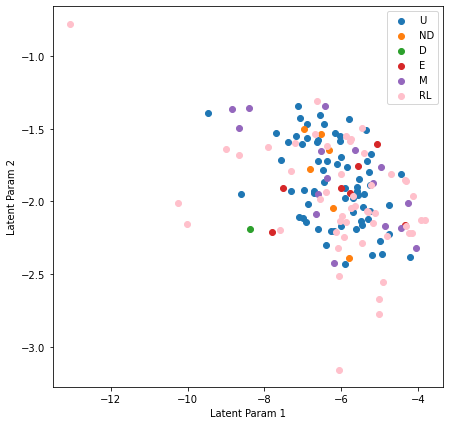

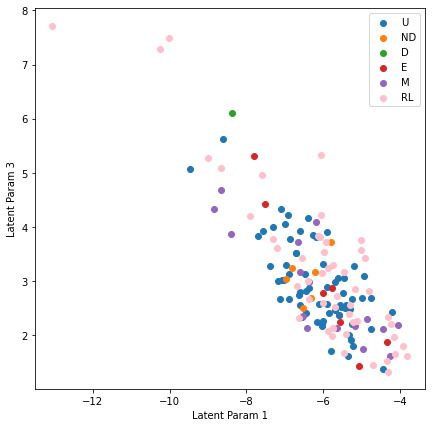

In [86]:
plot_params(1,2)
plot_params(1,3)
#plot_params(1,4)
#plot_params(1,5)
#plot_params(1,6)

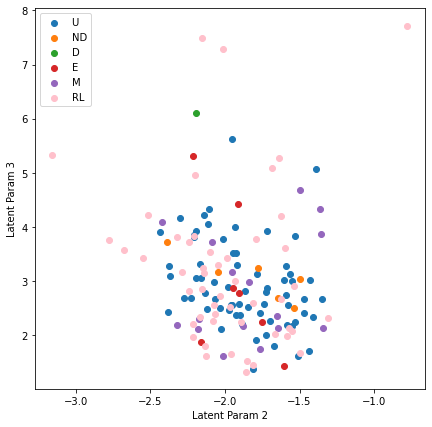

In [87]:
plot_params(2,3)
#plot_params(2,4)
#plot_params(2,5)
#plot_params(2,6)

Plot our spectra

In [88]:
sdss_name = dat["SDSS_NAME"].values
norm_coeffs = np.median(spectra, axis=1)[:, np.newaxis]
spec_norm = spectra / norm_coeffs

In [89]:
reconst = stacked_ae.predict(spec_norm)

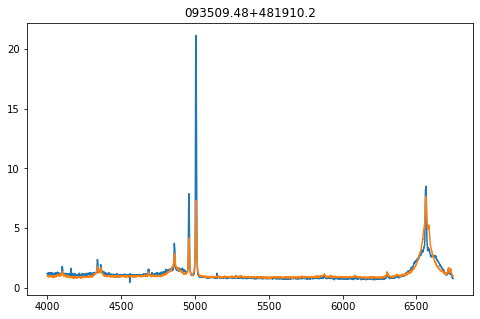

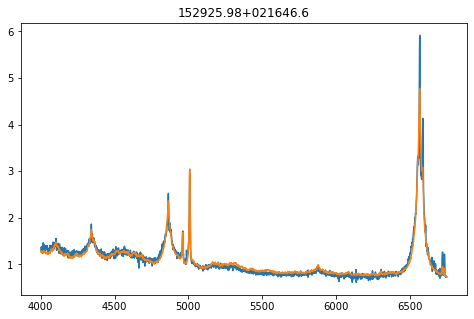

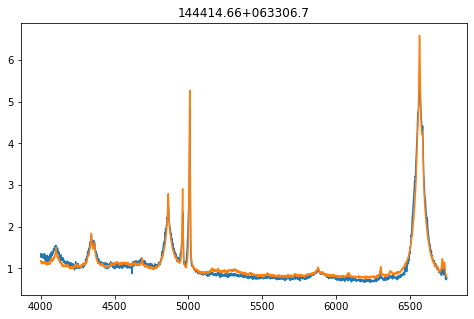

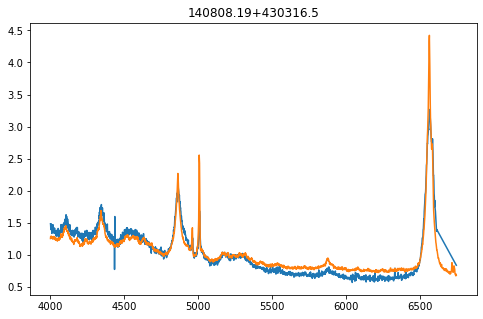

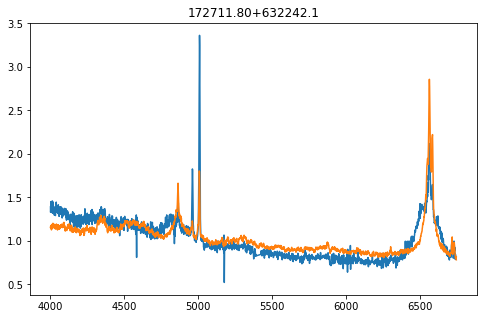

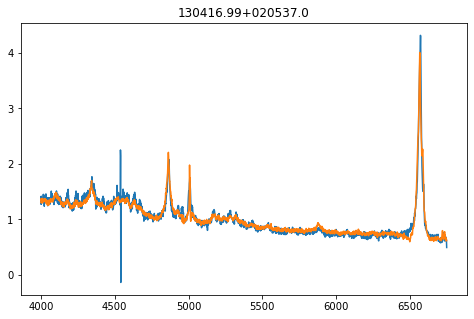

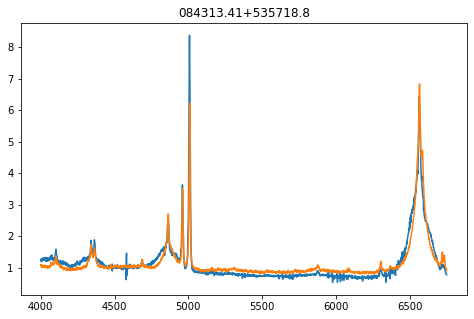

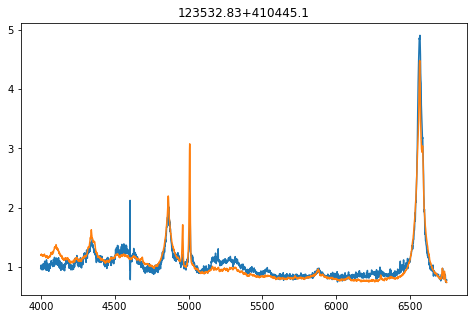

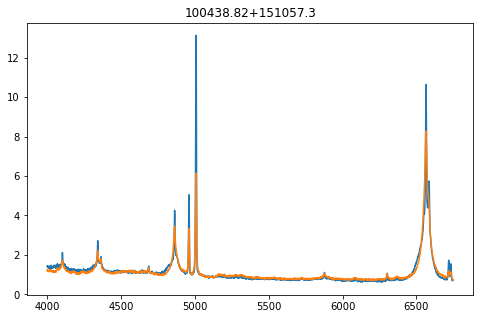

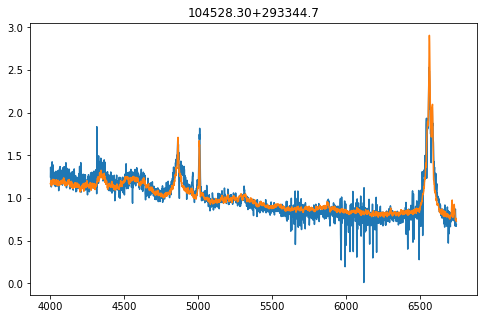

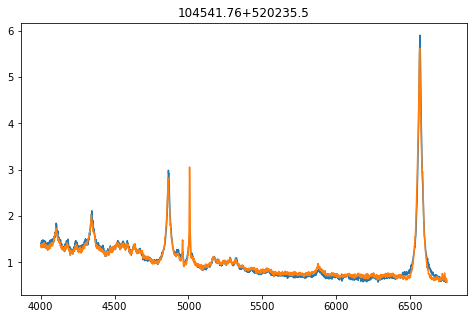

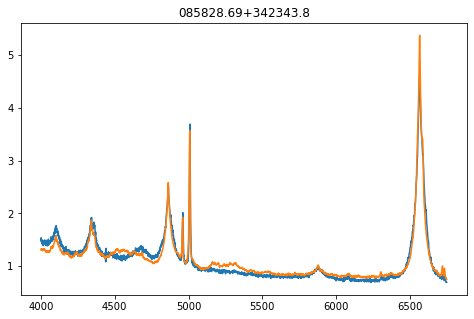

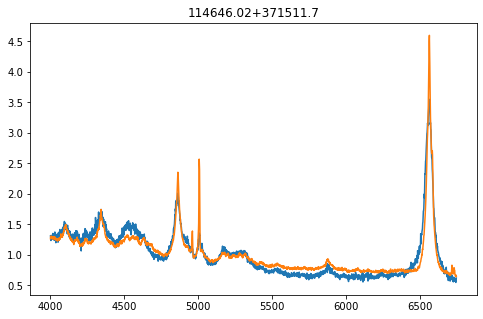

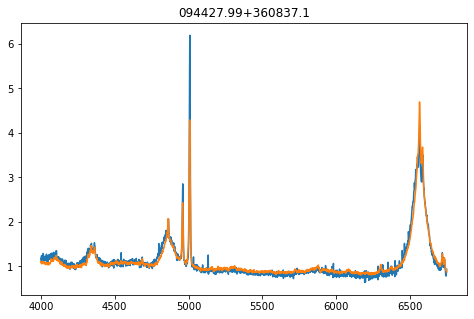

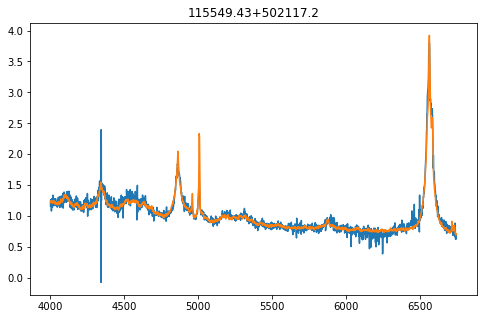

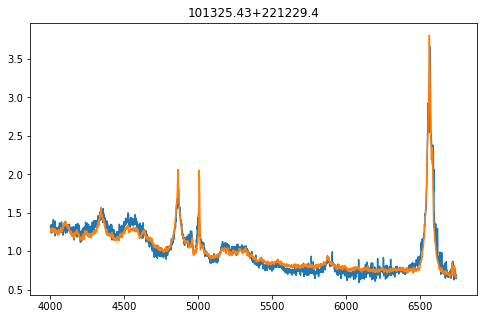

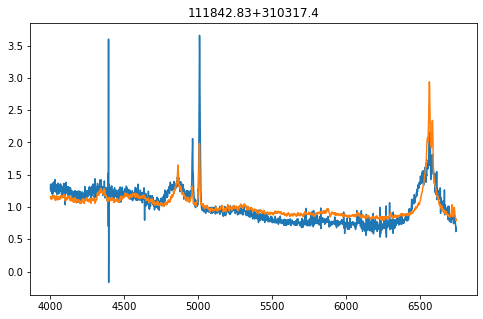

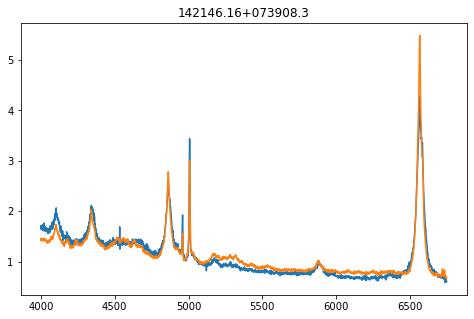

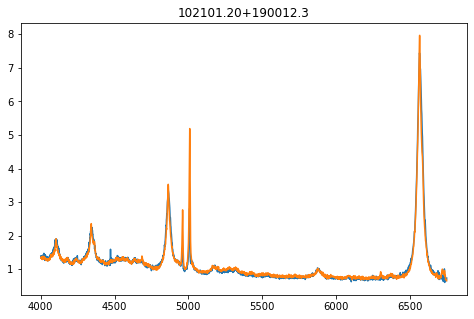

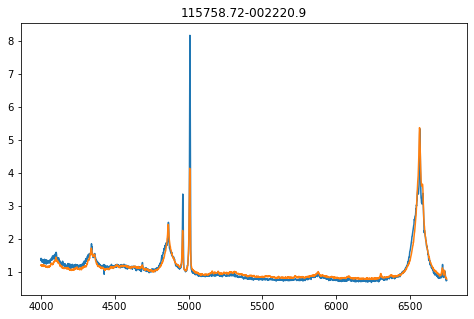

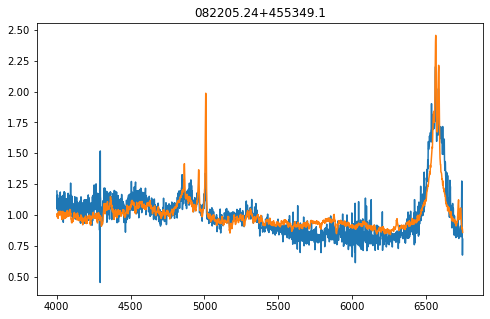

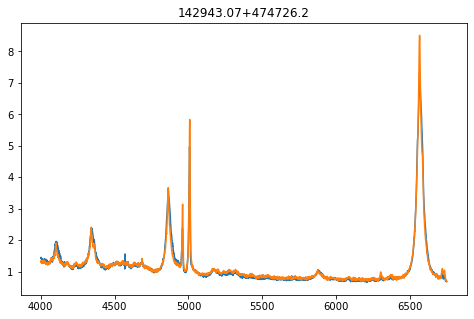

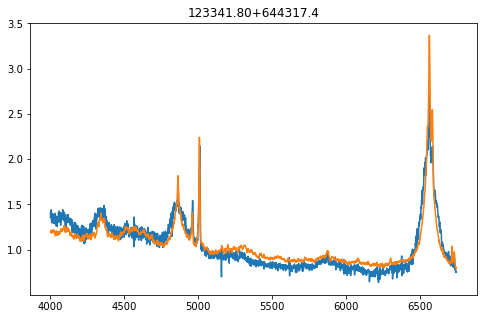

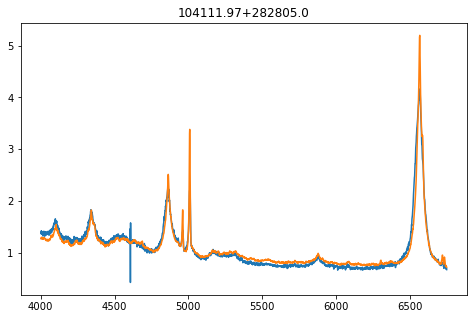

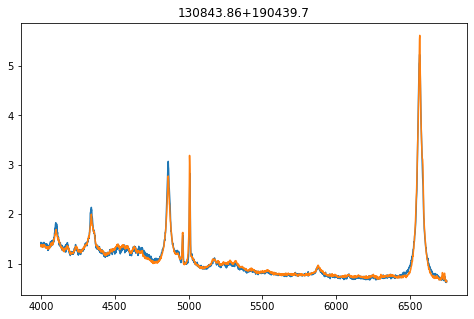

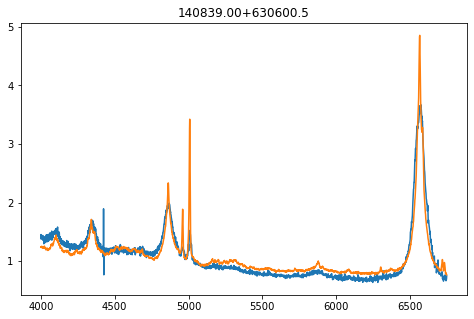

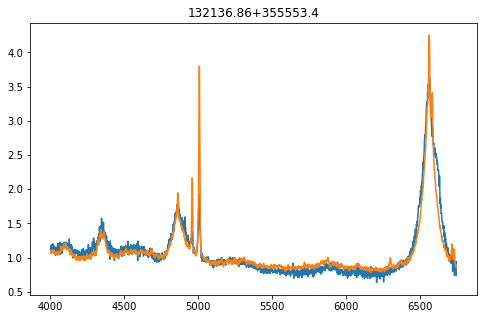

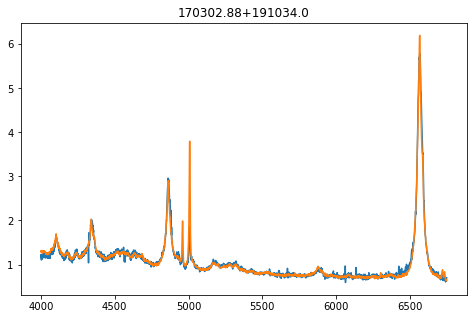

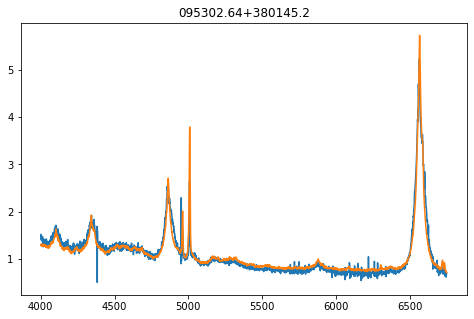

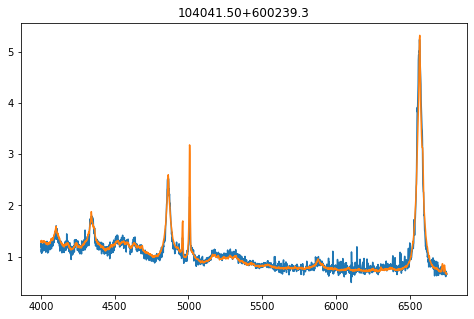

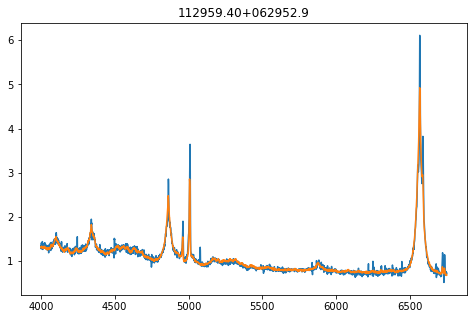

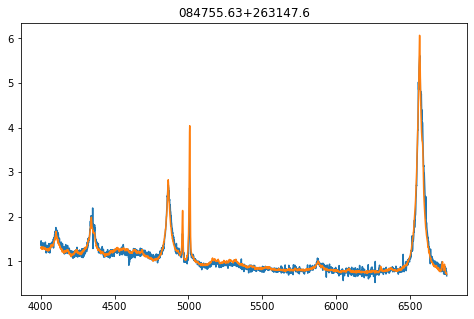

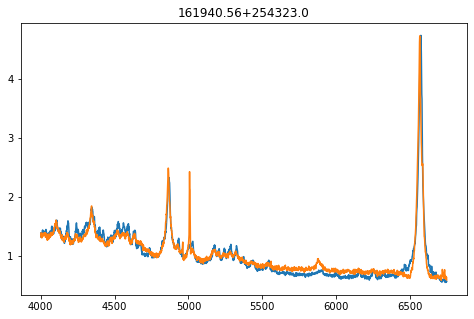

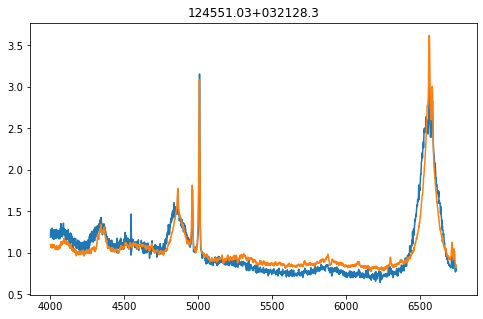

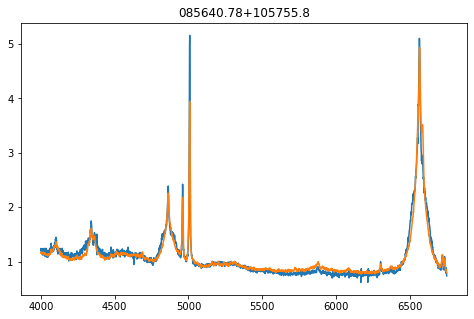

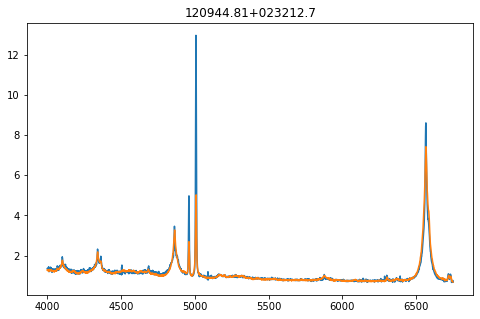

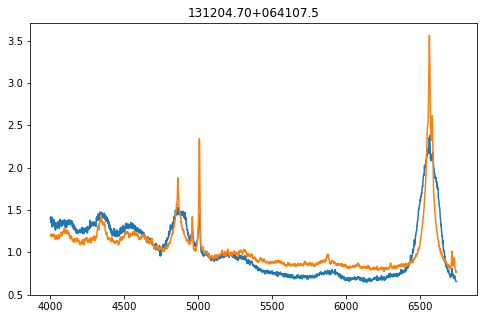

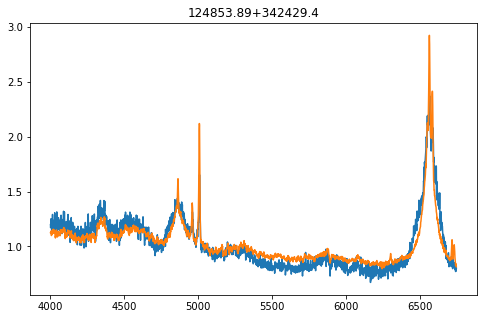

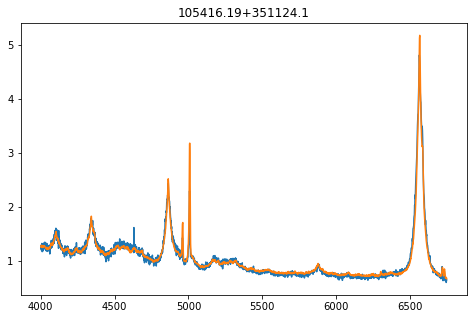

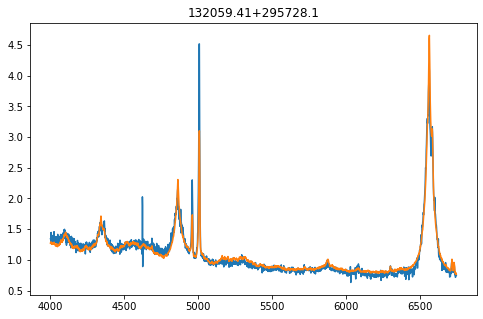

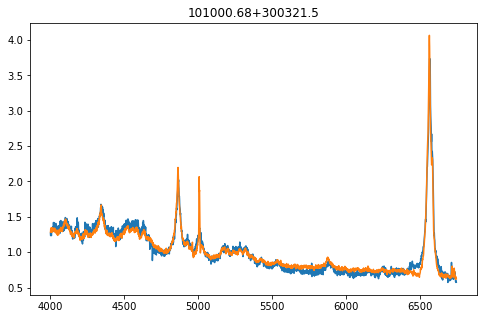

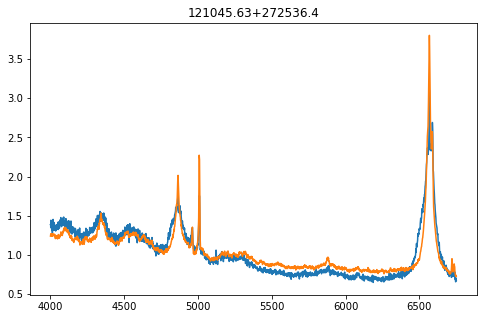

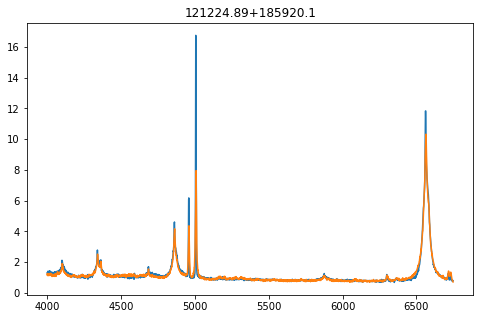

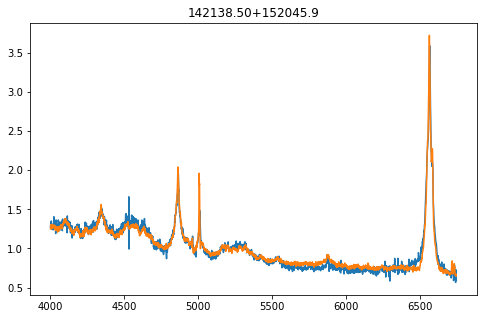

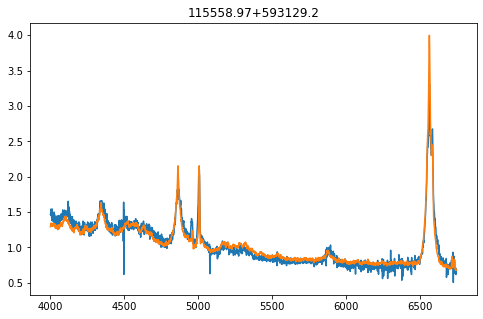

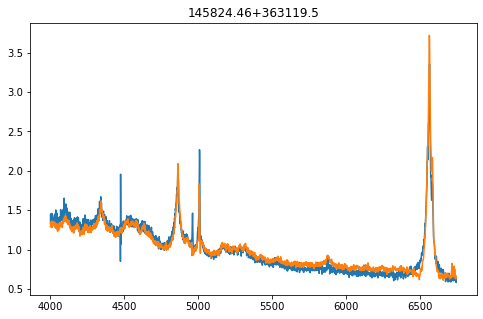

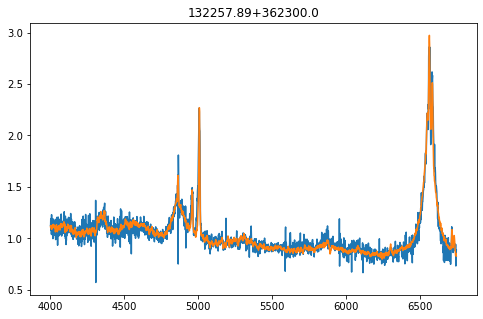

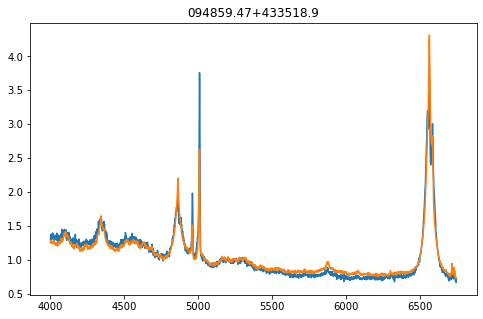

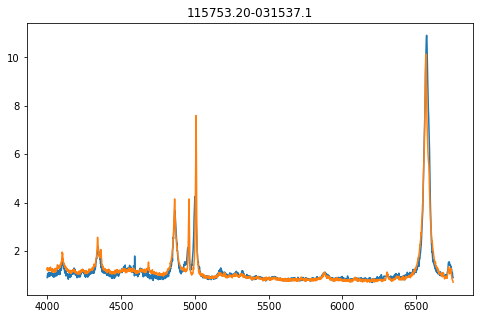

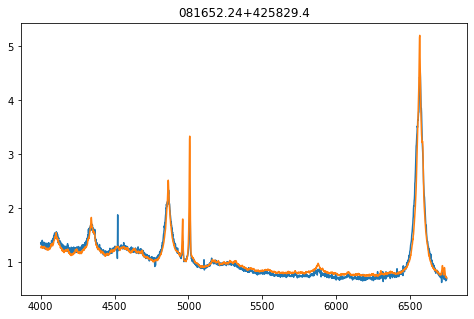

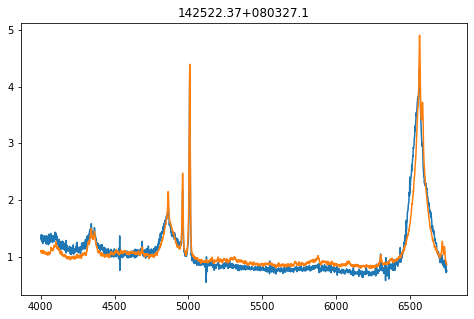

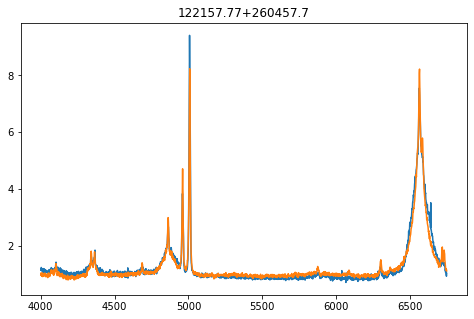

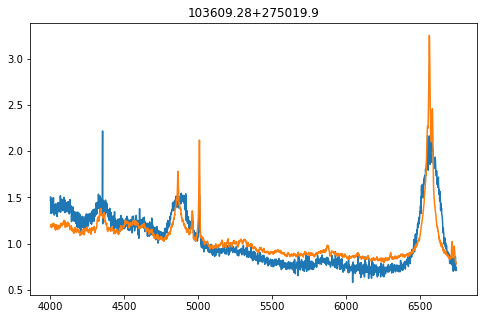

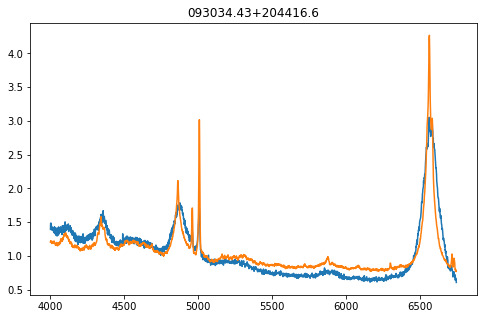

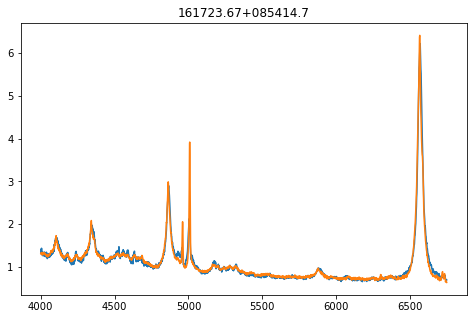

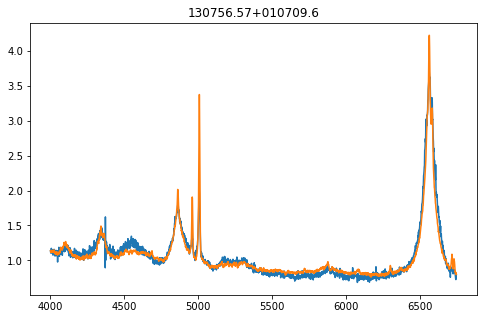

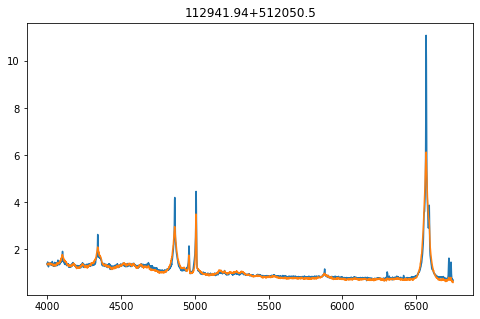

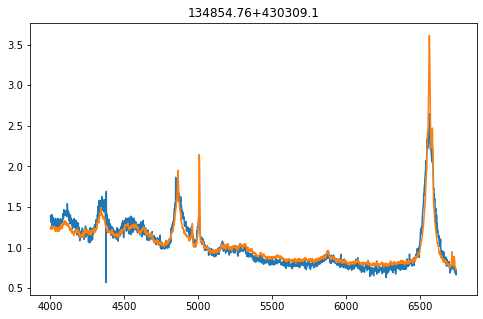

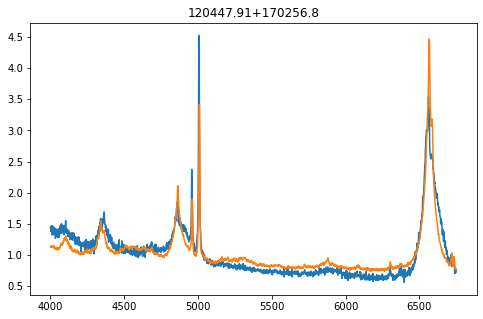

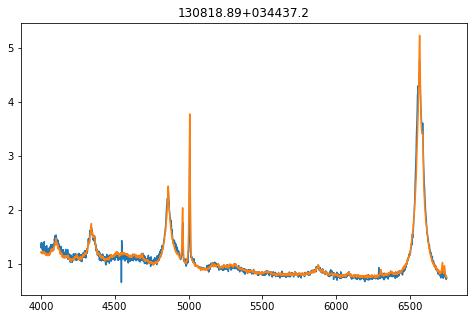

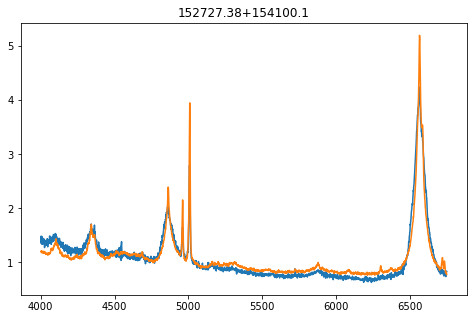

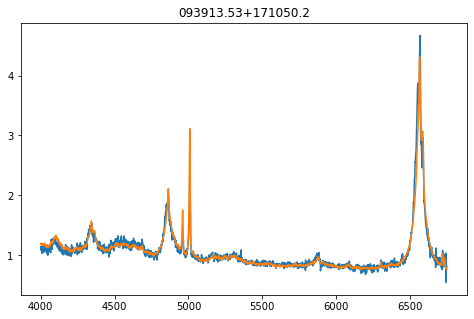

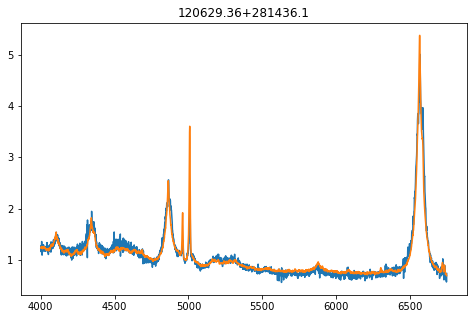

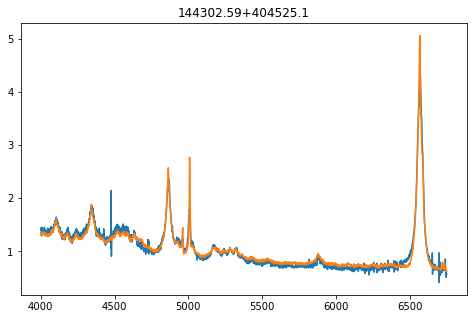

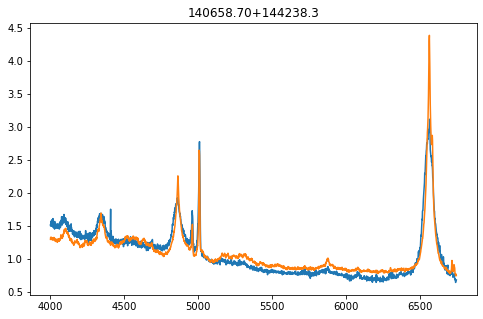

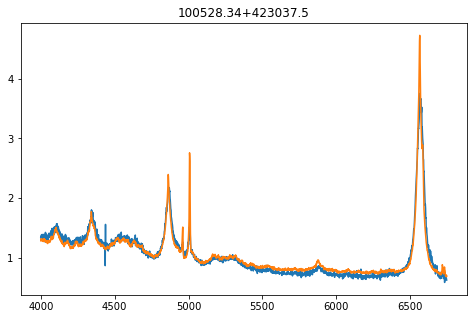

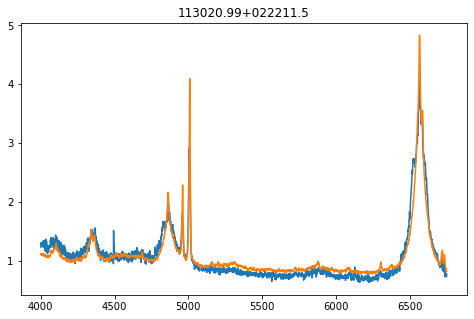

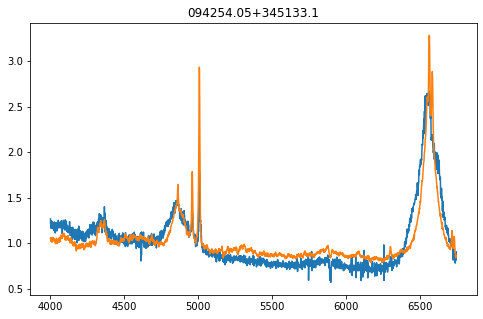

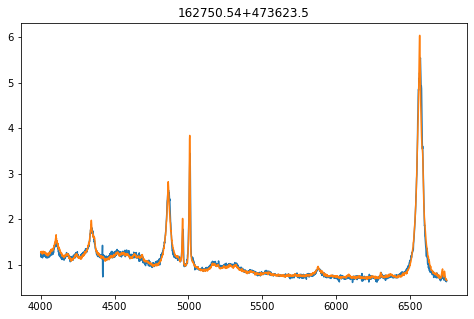

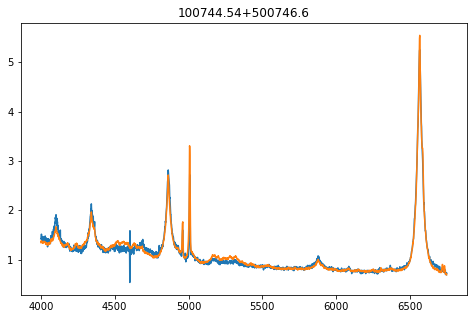

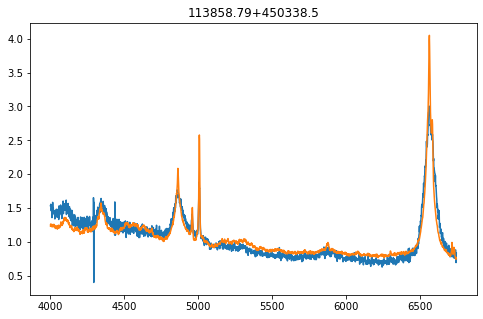

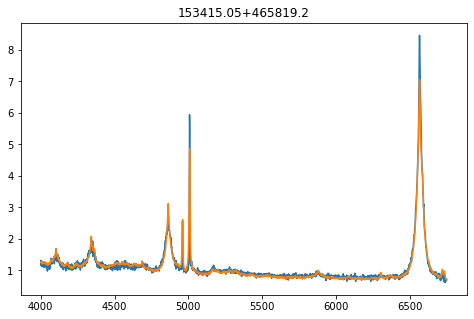

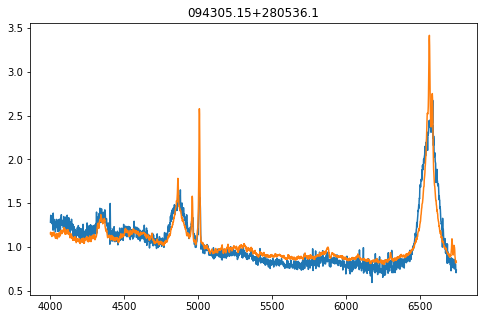

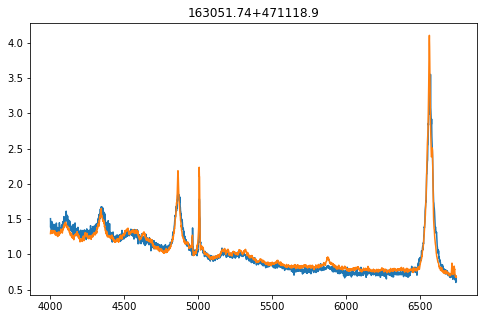

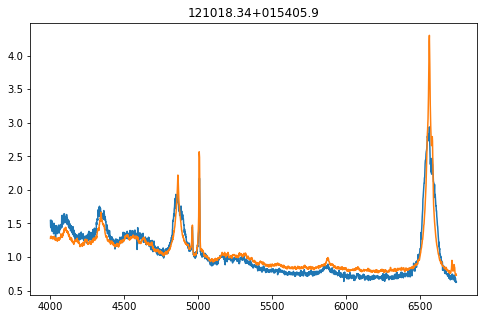

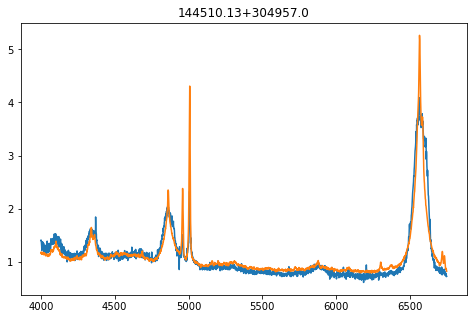

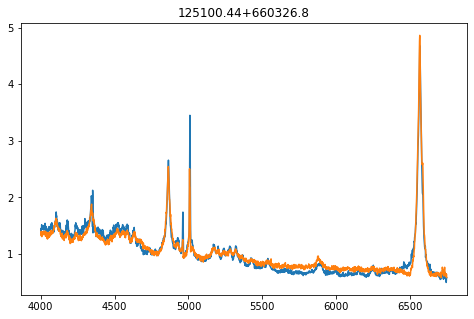

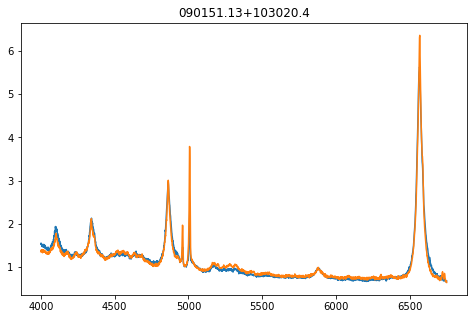

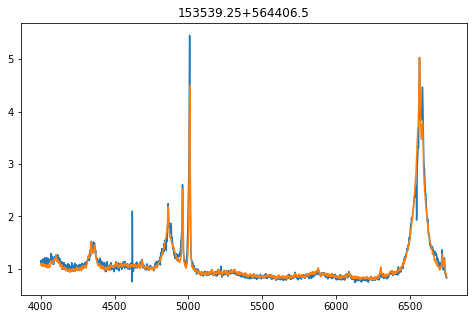

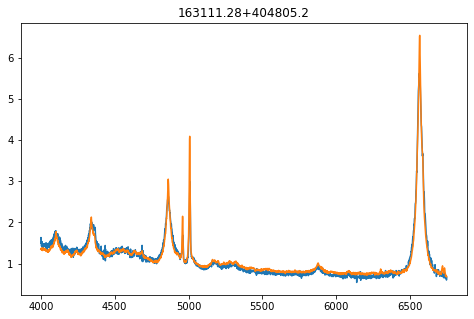

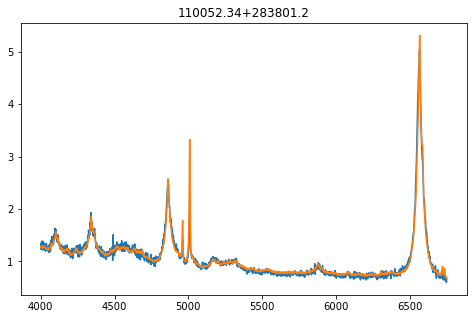

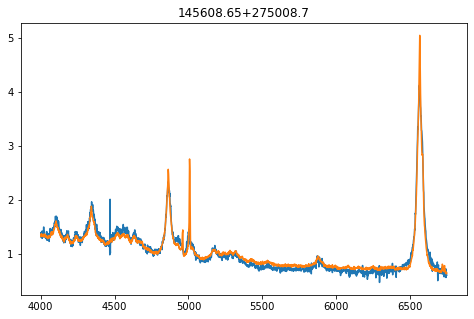

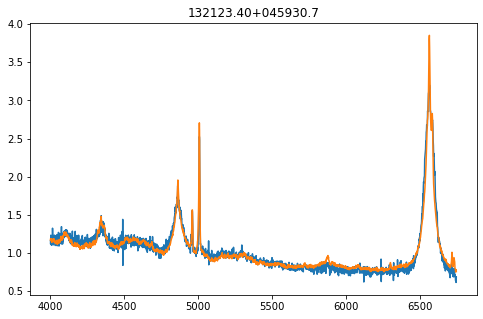

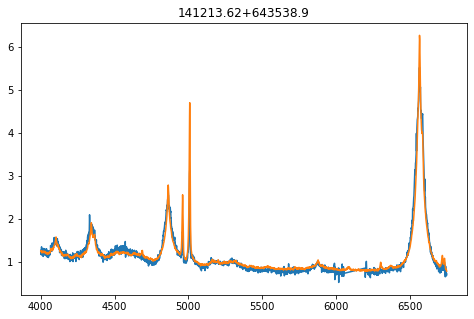

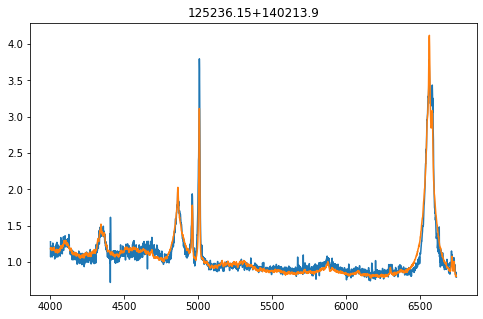

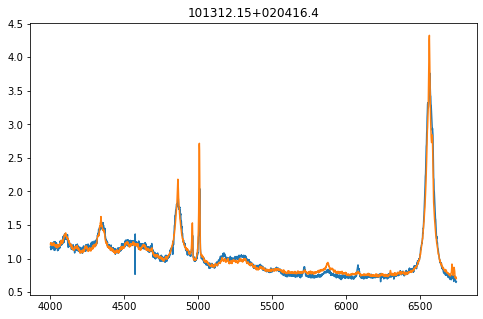

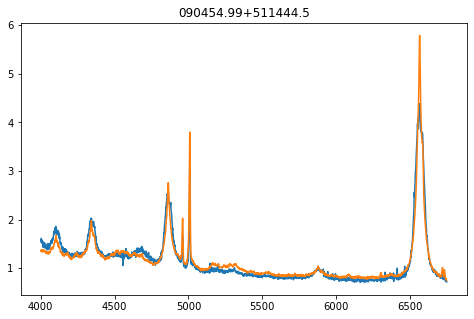

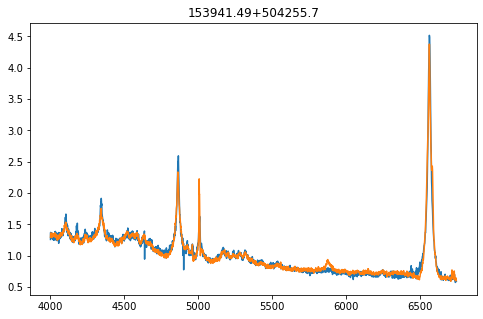

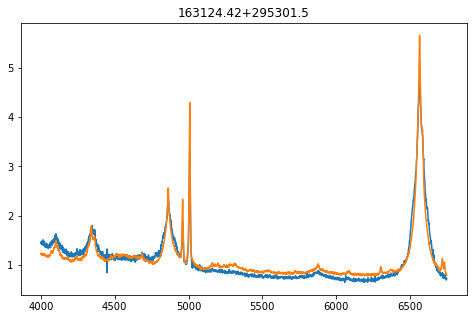

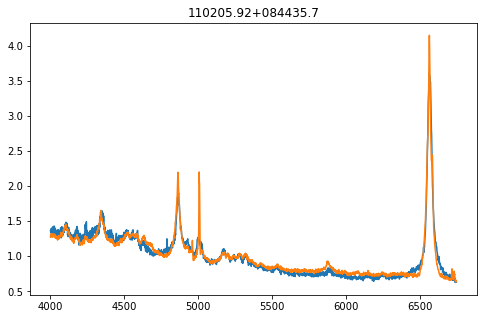

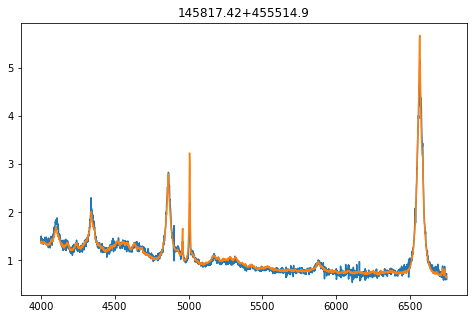

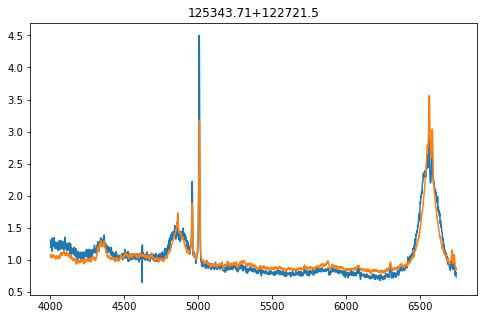

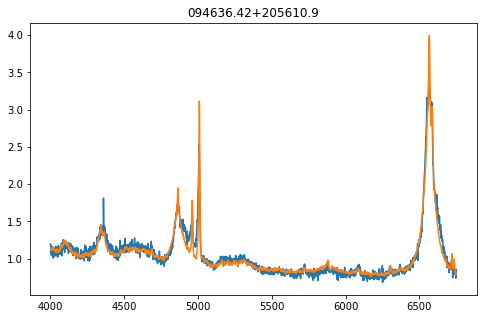

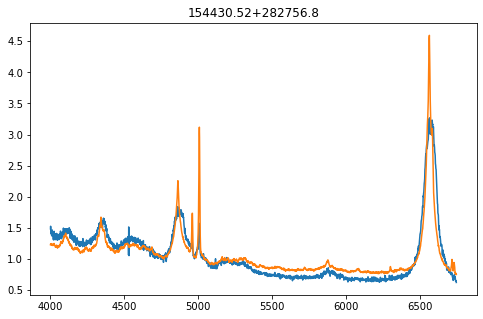

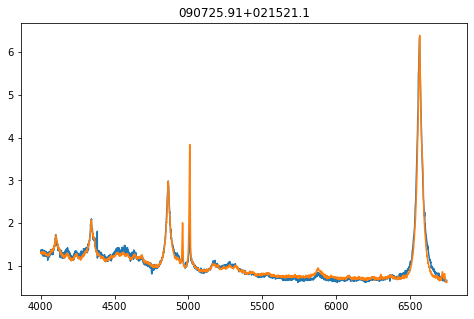

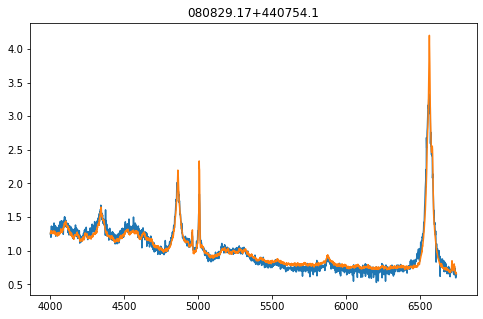

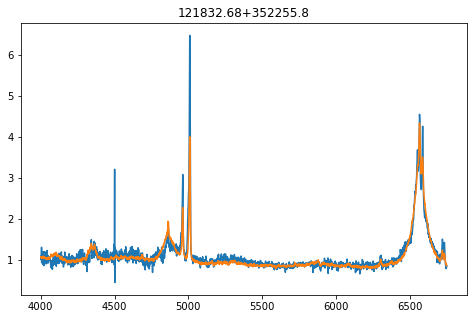

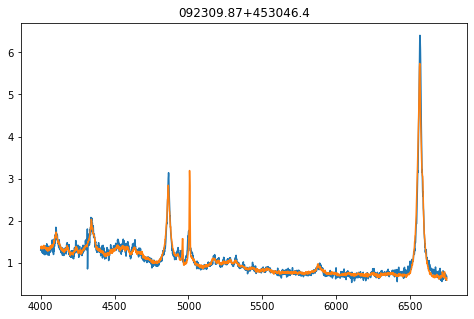

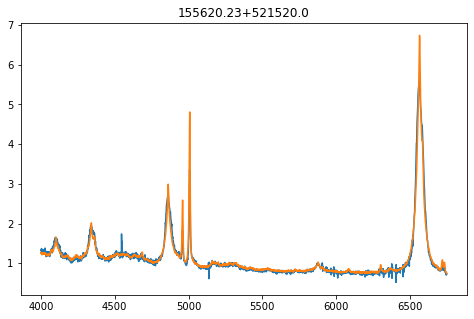

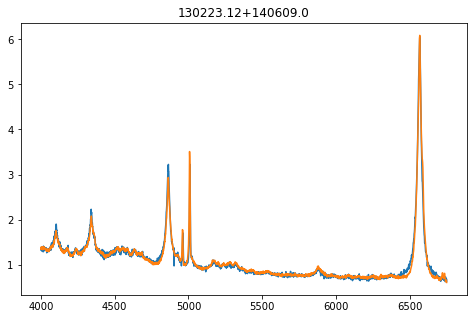

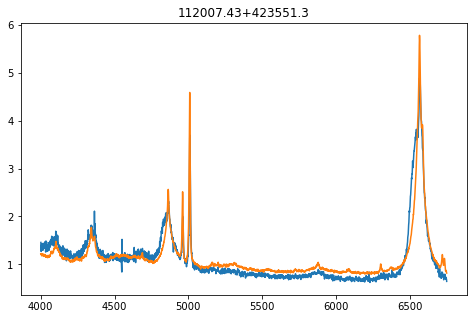

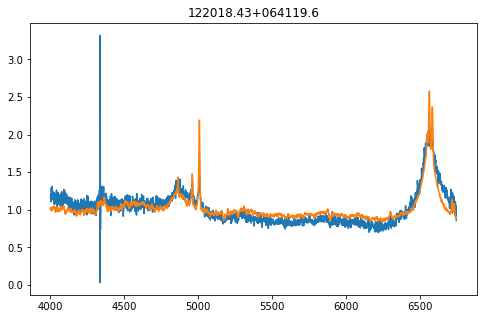

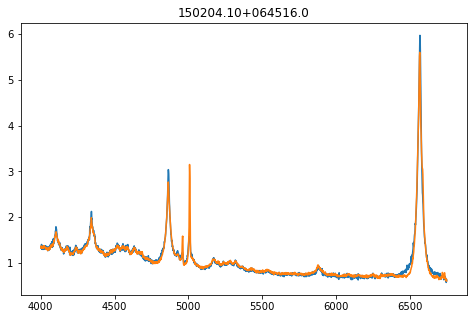

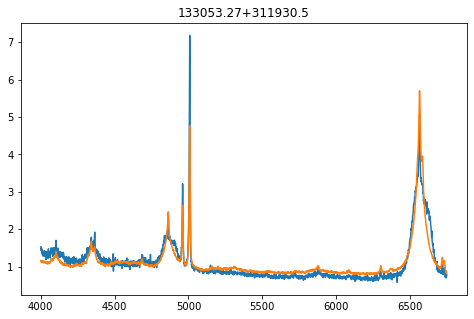

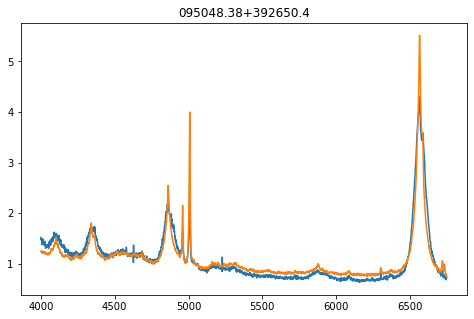

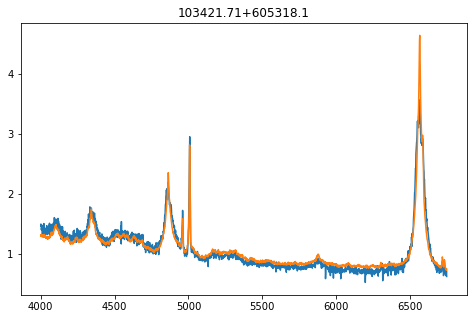

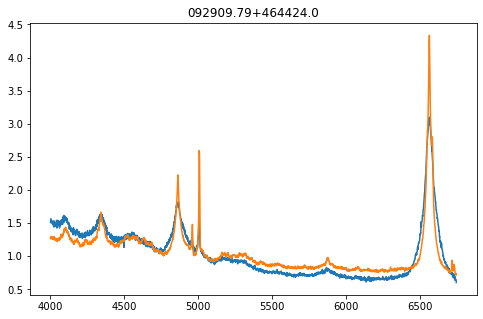

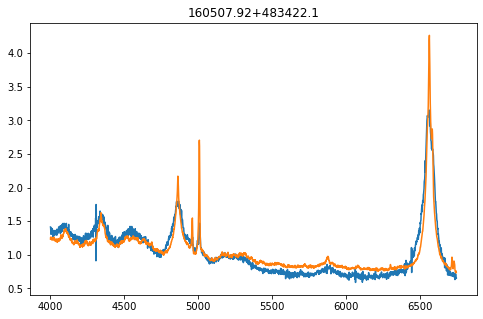

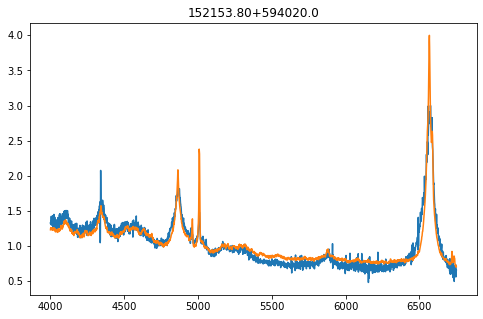

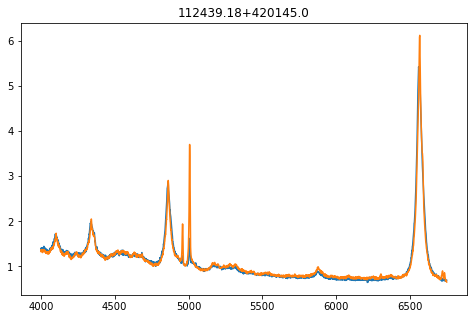

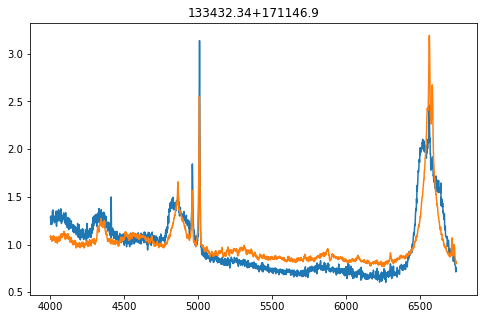

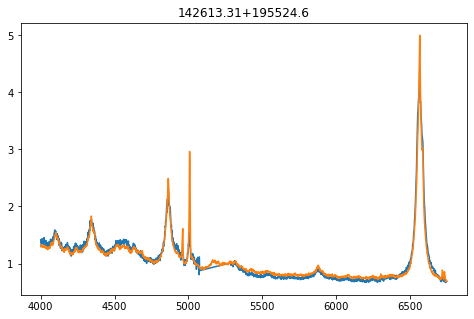

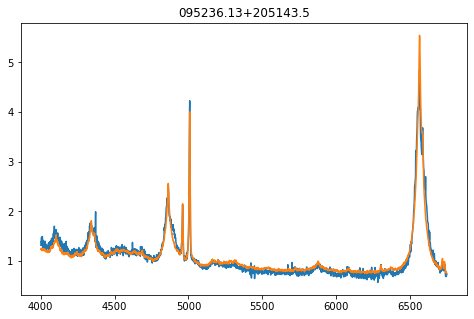

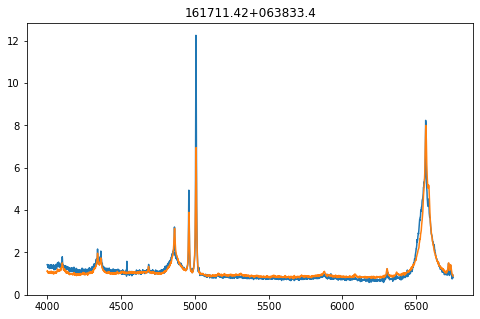

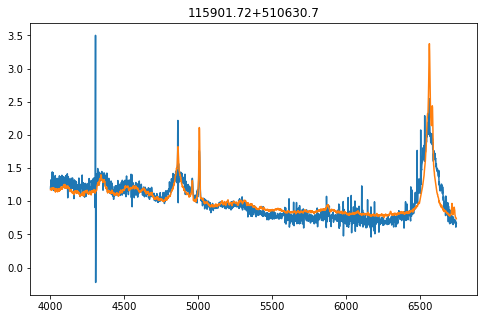

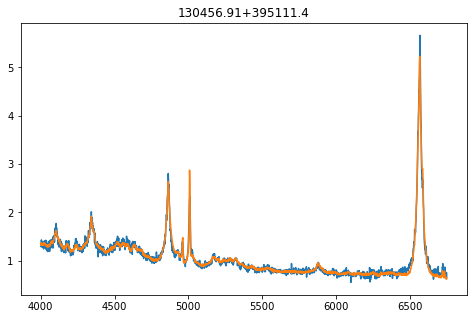

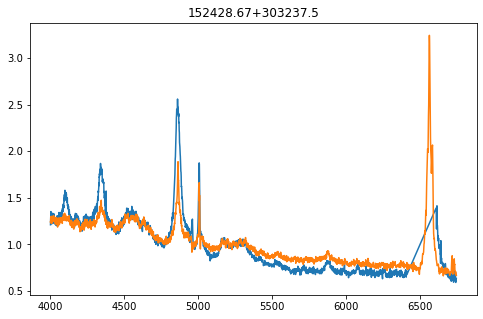

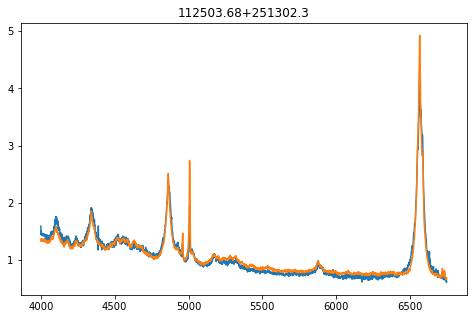

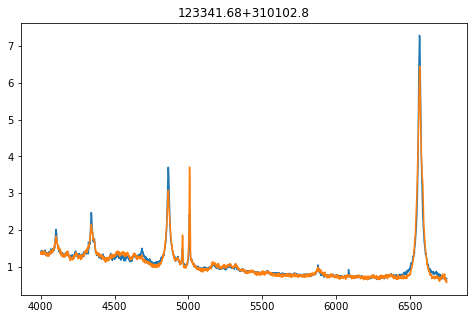

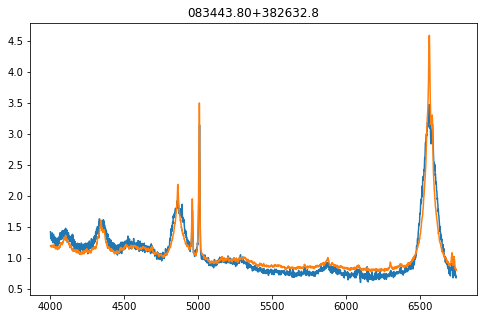

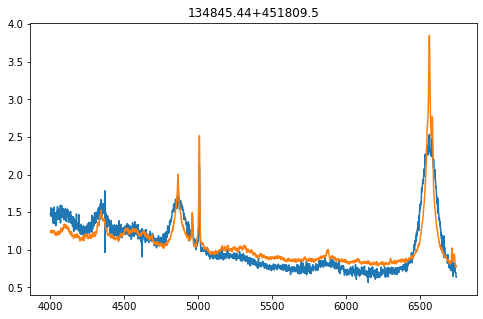

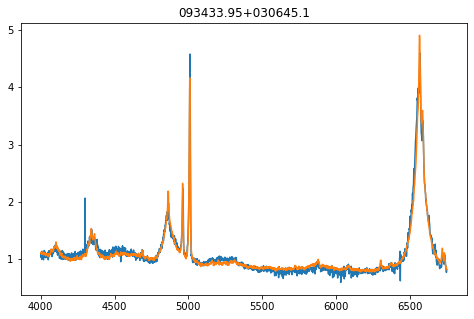

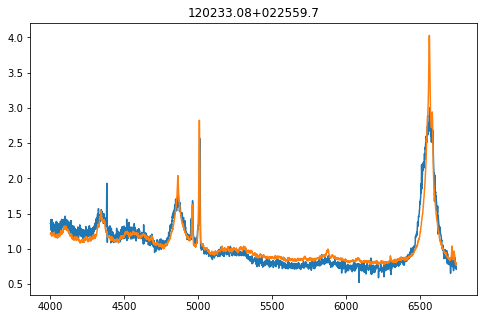

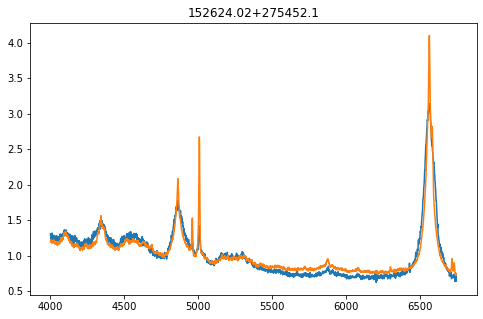

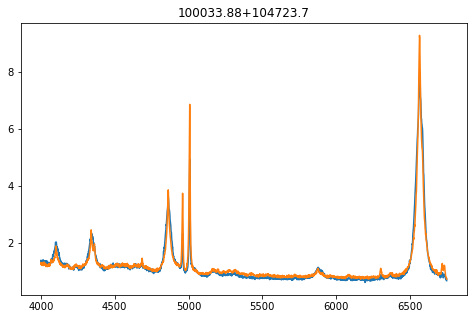

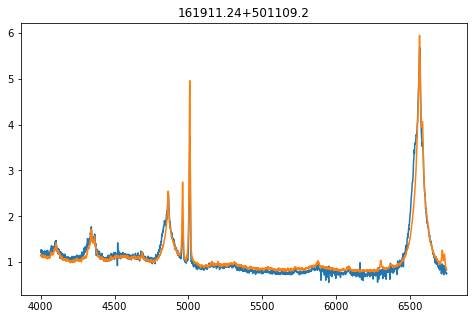

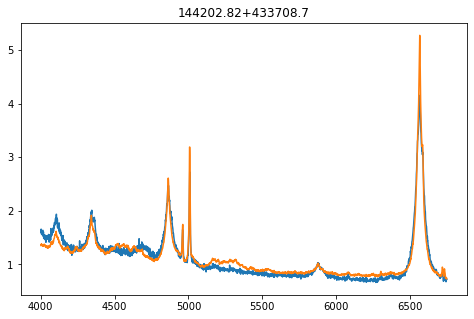

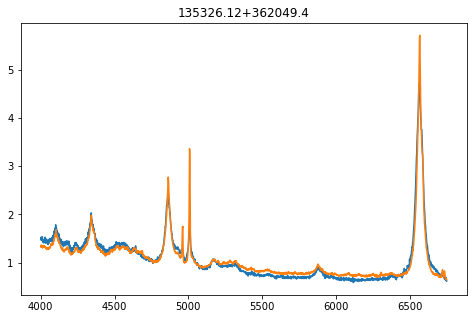

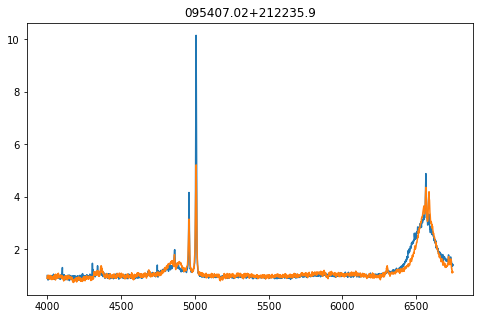

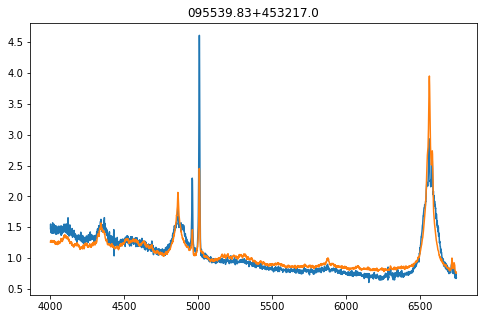

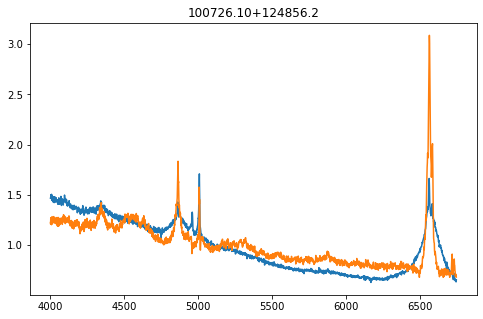

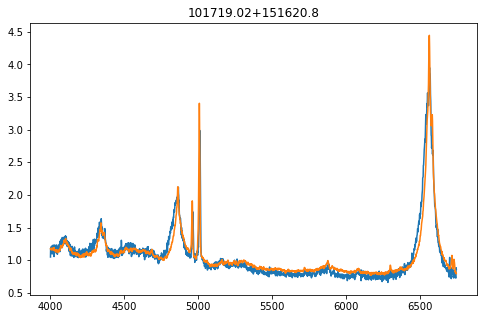

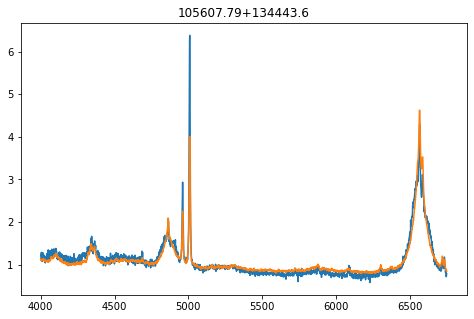

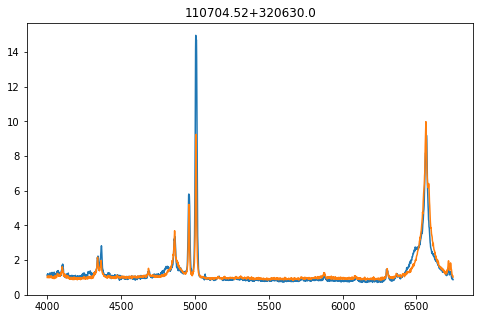

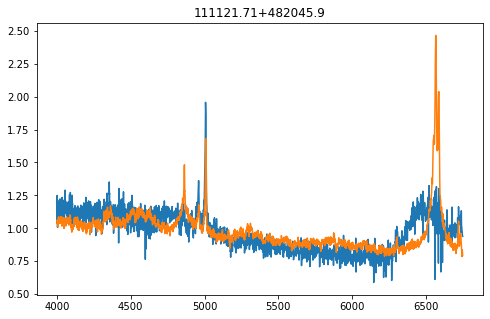

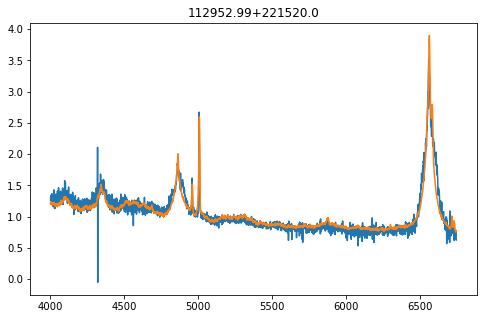

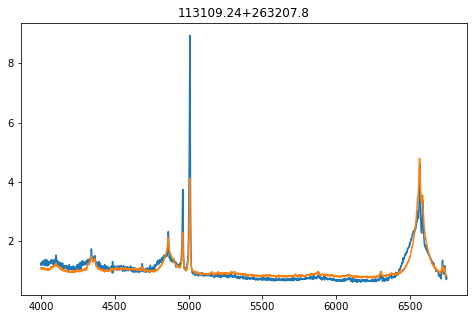

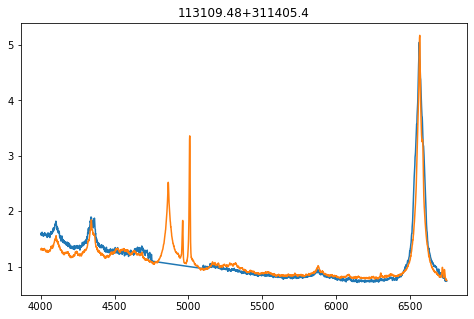

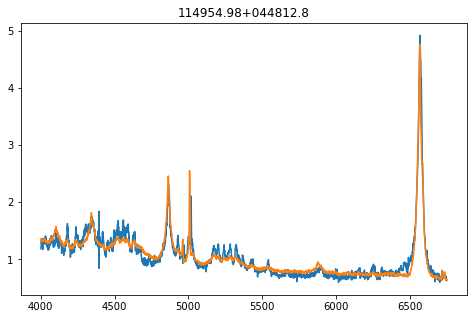

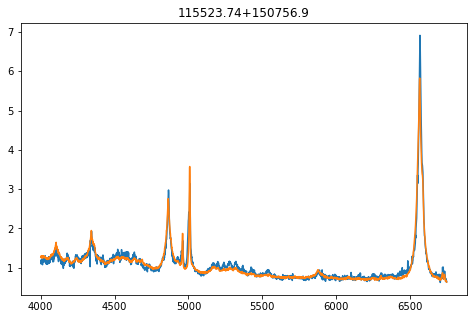

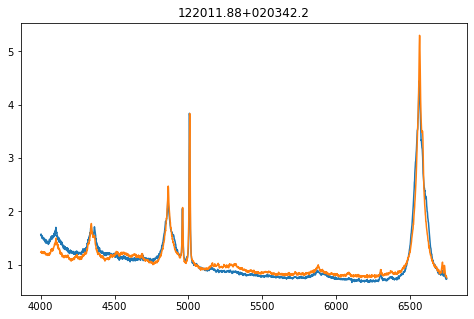

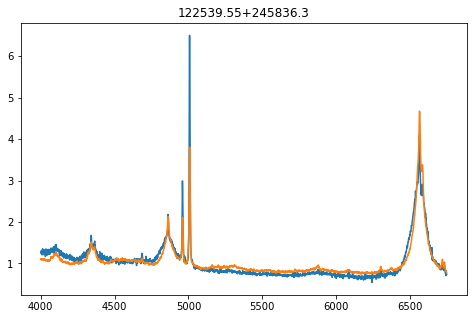

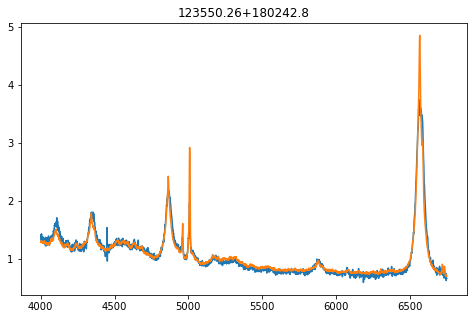

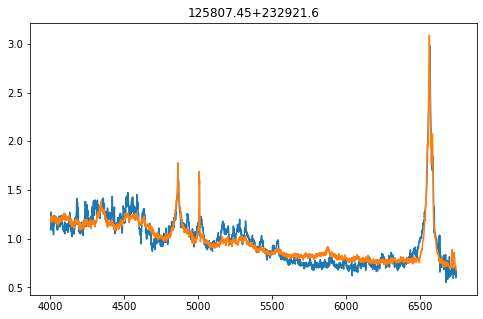

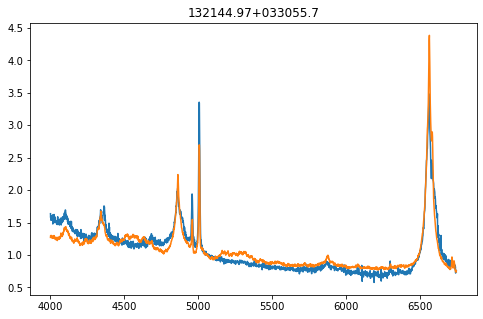

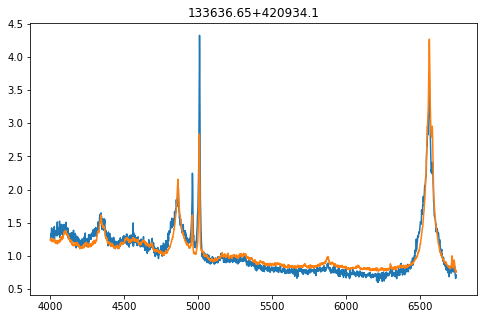

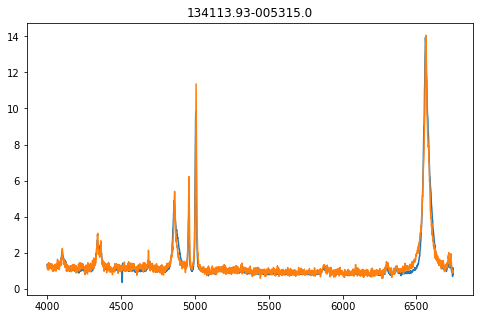

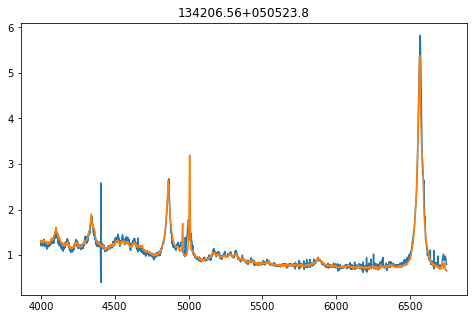

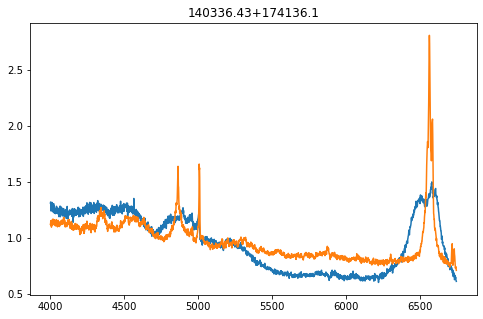

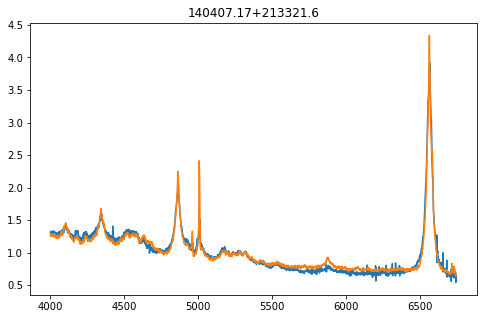

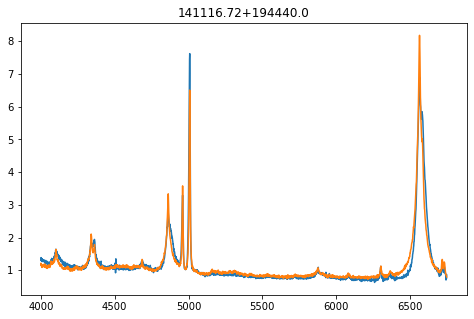

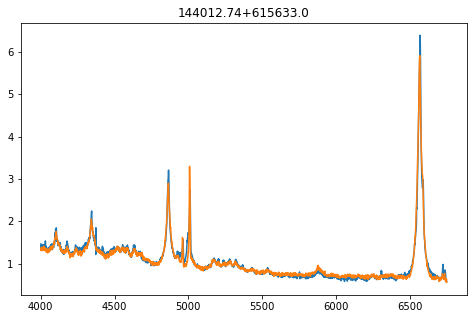

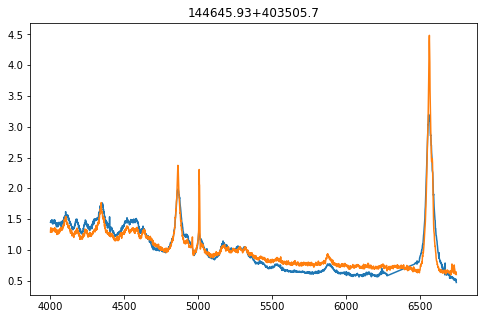

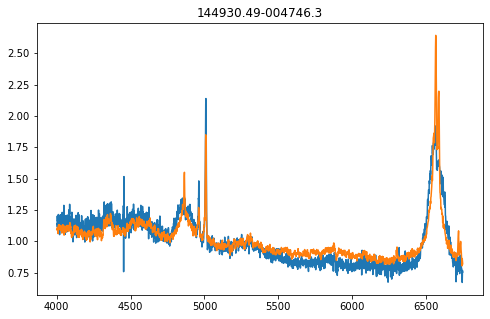

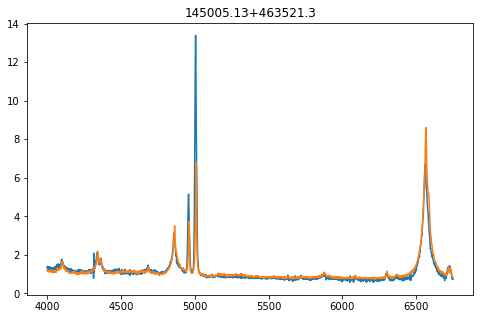

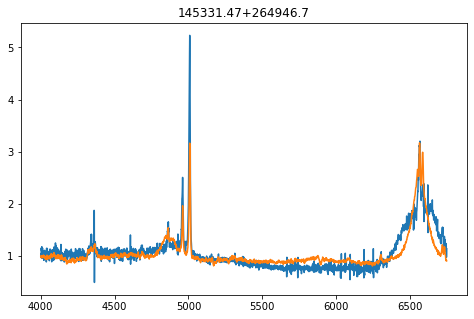

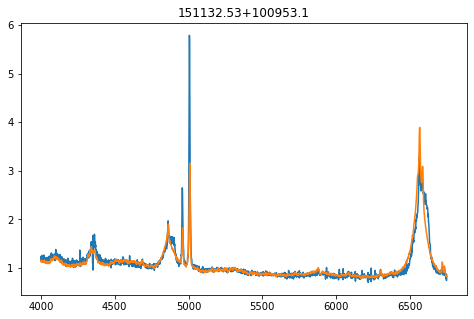

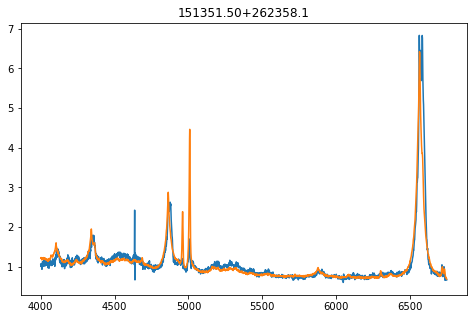

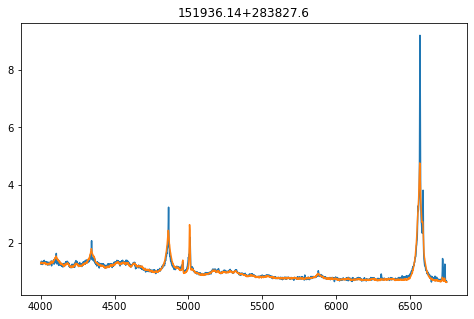

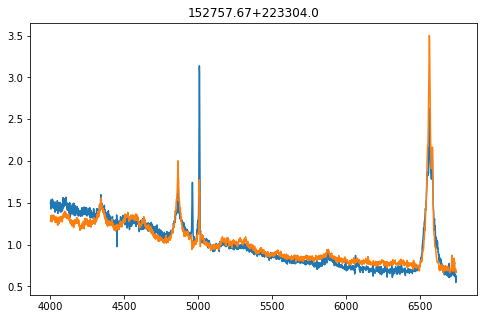

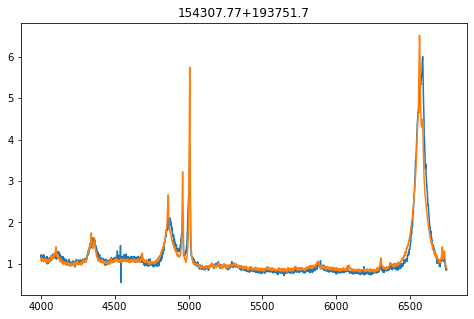

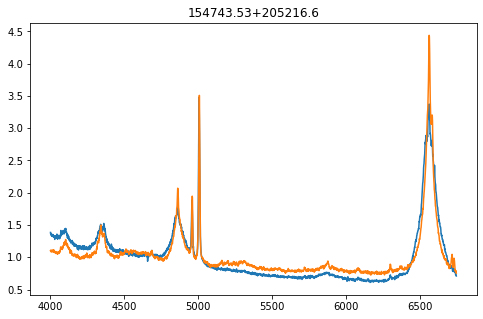

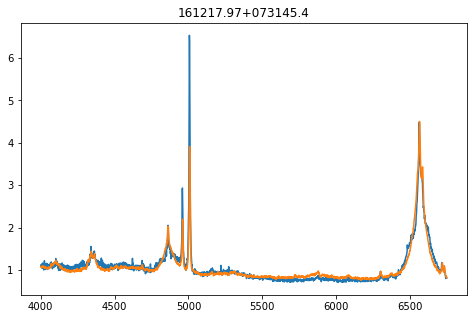

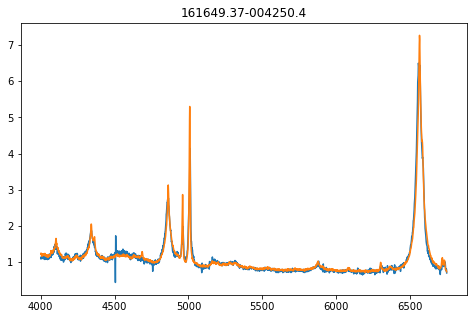

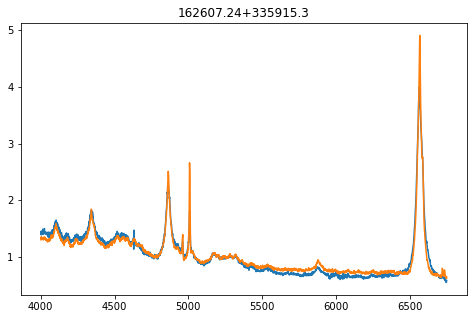

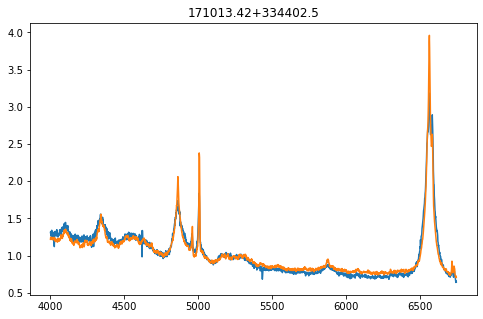

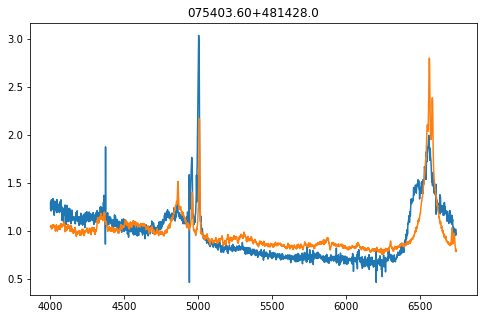

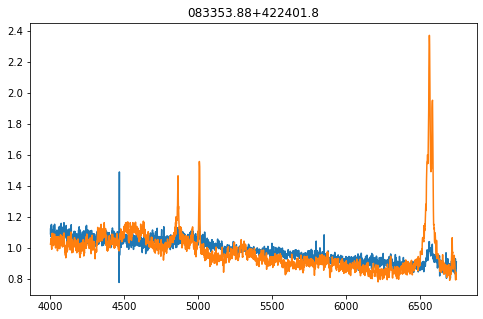

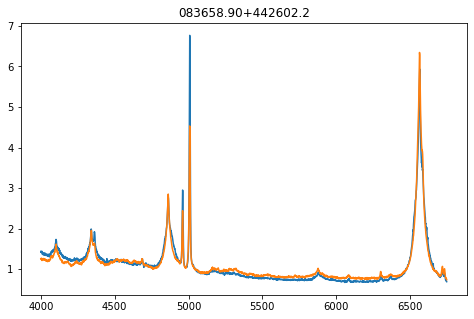

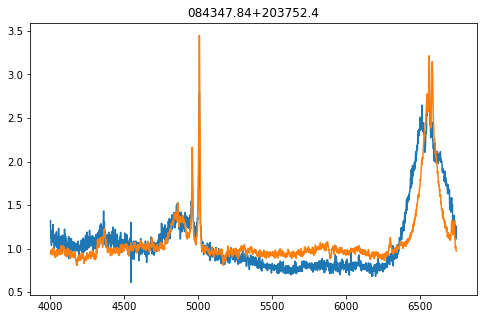

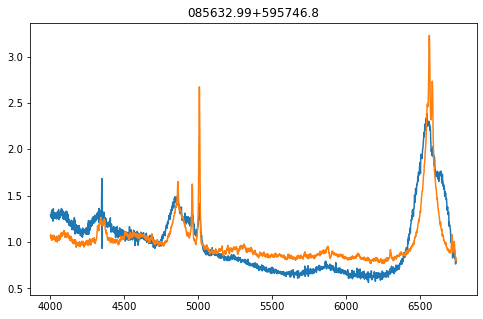

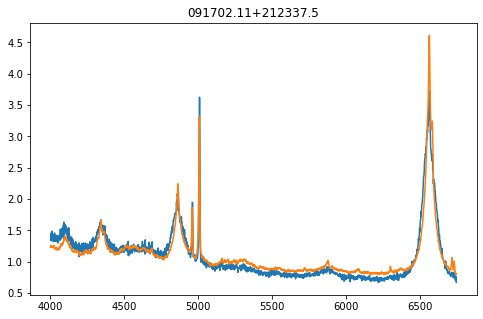

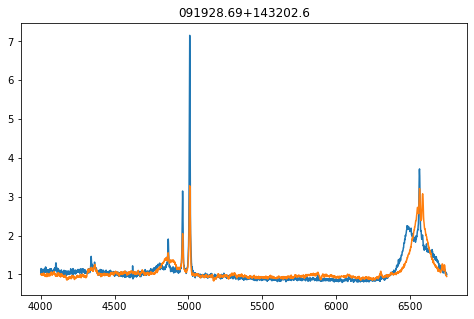

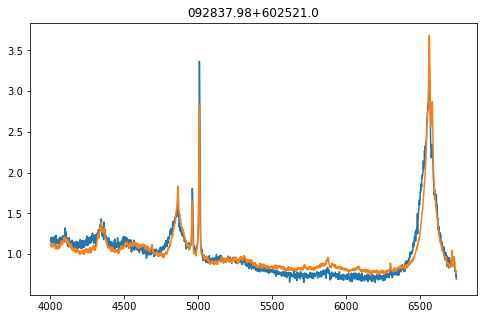

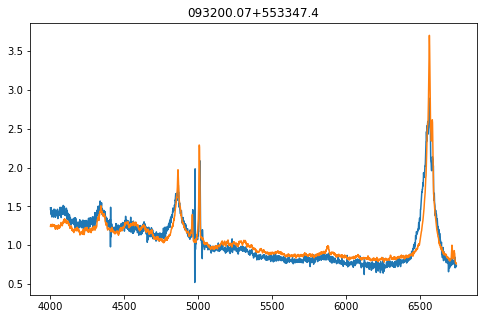

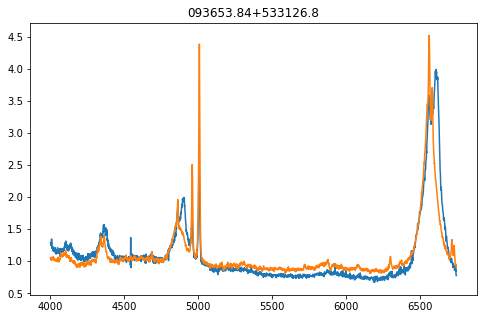

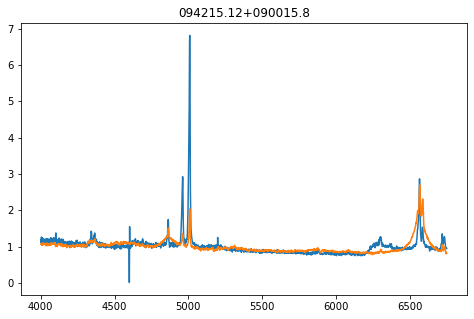

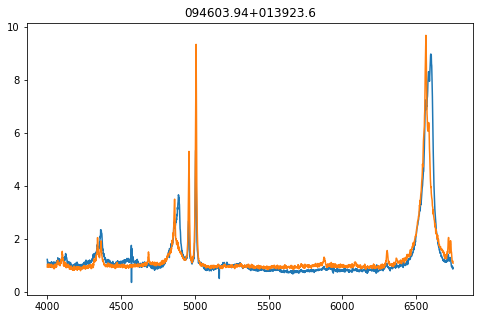

In [91]:
for i in range(len(spectra)):
    #reconst = stacked_ae.predict(np.array([X_valid[i]]))
    fig = plt.figure(figsize=(8,5))
    plt.plot(wave[i], spec_norm[i])
    plt.plot(wave[i], reconst[i])
    #plt.plot(wave_norm[3000+i], reconst[i])
    plt.title(sdss_name[i])
    plt.show()

In [96]:
rqqs_compressed.shape

(178, 3)

In [ ]:
rqqs_TSNE2 = TSNE2.transform(rqqs_compressed)

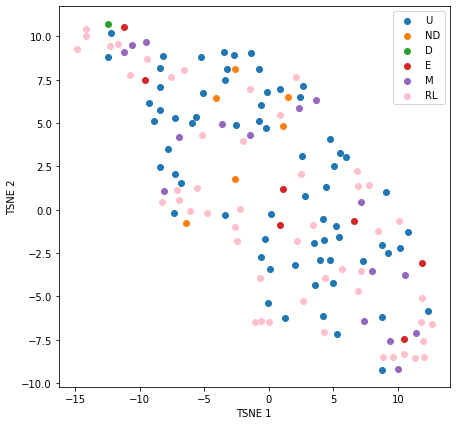

In [99]:
fig = plt.figure(figsize=(7,7))
plt.scatter(rqqs_TSNE2[A_morph["U"],0], rqqs_TSNE2[A_morph["U"],1], label="U")
plt.scatter(rqqs_TSNE2[A_morph["ND"],0], rqqs_TSNE2[A_morph["ND"],1], label="ND")
#plt.scatter(rqqs_TSNE2[A_morph["SR"],0], rqqs_TSNE2[A_morph["SR"],1], label="SR")
plt.scatter(rqqs_TSNE2[A_morph["D"],0], rqqs_TSNE2[A_morph["D"],1], label="D")
plt.scatter(rqqs_TSNE2[A_morph["E"],0], rqqs_TSNE2[A_morph["E"],1], label="E")
plt.scatter(rqqs_TSNE2[A_morph["M"],0], rqqs_TSNE2[A_morph["M"],1], label="M")
plt.scatter(rqqs_TSNE2[A_morph["RL"],0], rqqs_TSNE2[A_morph["RL"],1], color="pink", label="RL")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(loc="best")
plt.show()